# CitiGroup Modeling
In this notebook, the objective is to model the log returns of citi-group using the macro-economic factors and the data from the other banks.
- We will use lag terms of the other banks in our model as well, and see how our model fairs.
- We will use the full dataset first and then use various cross validation techniques to get a robust idea about the accuracy of our model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kstest
import statsmodels.stats.api as sms
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.regression.quantile_regression import QuantReg

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Regression Course Project/data/Transformed_data.csv")
data.head(5)

Date  JPMorgan Chase  Citigroup  Bank of America  Wells Fargo  \
0  2001-01-23       -0.028607   0.003423        -0.011104    -0.006277   
1  2001-01-30        0.079779   0.023859         0.096347     0.045017   
2  2001-02-06       -0.068381  -0.019223        -0.084801    -0.019845   
3  2001-02-13       -0.022047  -0.009843        -0.014229    -0.017843   
4  2001-02-20       -0.023544  -0.064111        -0.022545    -0.026555   

   Goldman Sachs  Morgan Stanley     S&P500        GDP  Inflation  \
0       0.053110        0.033678  33.750000  15.693993   0.076557   
1       0.022335       -0.021099  13.329956  13.842892   0.055877   
2      -0.085036       -0.000588 -21.469971  12.101463   0.039729   
3      -0.028394       -0.069960 -33.459961  10.469705   0.028114   
4      -0.098147       -0.140027 -39.860107   8.947619   0.021031   

   Federal Funds Rate  GDP_diff  Inflation_diff  Federal Funds Rate_diff  \
0               -0.23 -1.960772       -0.025213                    -0.48   
1               -0.07 -1.851100       -0.020680                     0.16   
2               -0.42 -1.741429       -0.016148                    -0.35   
3               -0.02 -1.631758       -0.011615                     0.40   
4                0.11 -1.522087       -0.007083                     0.13   

   S&P500_diff  
0     7.900024  
1   -20.420044  
2   -34.799927  
3   -11.989990  
4    -6.400146

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     821 non-null    datetime64[ns]
 1   JPMorgan Chase           821 non-null    float64       
 2   Citigroup                821 non-null    float64       
 3   Bank of America          821 non-null    float64       
 4   Wells Fargo              821 non-null    float64       
 5   Goldman Sachs            821 non-null    float64       
 6   Morgan Stanley           821 non-null    float64       
 7   S&P500                   821 non-null    float64       
 8   GDP                      821 non-null    float64       
 9   Inflation                821 non-null    float64       
 10  Federal Funds Rate       821 non-null    float64       
 11  GDP_diff                 821 non-null    float64       
 12  Inflation_diff           821 non-nul

In [ ]:
df = data.drop(columns=['S&P500','GDP','Inflation','Federal Funds Rate'])
df.columns

Index(['Date', 'JPMorgan Chase', 'Citigroup', 'Bank of America', 'Wells Fargo',
       'Goldman Sachs', 'Morgan Stanley', 'GDP_diff', 'Inflation_diff',
       'Federal Funds Rate_diff', 'S&P500_diff'],
      dtype='object')

In [ ]:
bank_columns = ['JPMorgan Chase', 'Bank of America', 'Wells Fargo', 'Citigroup', 'Goldman Sachs', 'Morgan Stanley']
for col in bank_columns:
  df[col] = np.exp(df[col]) - 1

## Modeling Phase I
We perform the modelling with the full dataset

Here we write a function to plot the model fittings vs the actual, the residual plot, the histogram of the residuals, the studentized residual plot and the qq plot of the residuals. We take as input the trained model and the actual values of y.

We perform backward selection for variable selection.

In [ ]:
def diagnostic_plots(X, y, model_fit,dates,robust=False):
    """
    Function to create diagnostic plots for a linear regression model.

    Args:
        X (array-like): The independent variables.
        y (array-like): The dependent variable.
        model_fit (statsmodels.regression.linear_model.RegressionResultsWrapper): The fitted model.
        dates : The dates
        robust : The indicator to show if the regression is robust or not, default is False
    """

    # Fitted values
    y_pred = model_fit.fittedvalues

    # Residuals
    residuals = model_fit.resid

    # Studentized residuals
    studentized_residuals = model_fit.get_influence().resid_studentized_internal if robust==False else [0]*len(residuals)

    # Create plots
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))

    # Plot 1: Fitted vs Actual Values
    axes[0, 0].plot(dates,y,label="Actual Values")
    axes[0, 0].plot(dates,y_pred,label="Fitted Values")
    axes[0, 0].set_title('Fitted vs. Actual Values')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Values')
    axes[0, 0].legend()

    # Plot 2: Residual Plot
    axes[0, 1].scatter(y_pred, residuals)
    axes[0, 1].axhline(y=0, color='red', linestyle='--')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].set_xlabel('Fitted Values')
    axes[0, 1].set_ylabel('Residuals')


    # Plot 3: Histogram of Residuals
    axes[1, 0].hist(residuals, bins=20,density=True)
    axes[1, 0].set_title('Histogram of Residuals')
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')

    # Plot 4: QQ Plot of Residuals
    stats.probplot(residuals, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('QQ plot of Residuals')

    # Plot 5 : Studentized Residuals
    axes[2,0].scatter(y_pred, studentized_residuals)
    axes[2,0].axhline(y=0, color='green', linestyle='--')
    axes[2,0].axhline(y=3, color='red', linestyle='--')
    axes[2,0].axhline(y=-3, color='red', linestyle='--')
    axes[2,0].set_title('Studentized Residual Plot')
    axes[2,0].set_xlabel('Fitted Values')

    # Plot 6: Residual Plot with time
    axes[2, 1].plot(dates,residuals,label="Actual Values")
    axes[2,1].set_title("Residuals with Time")
    axes[2,1].set_xlabel("Date")
    axes[2,1].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()


In [ ]:
# Create lagged variables for the banks and macroeconomic factors
for i in range(1, 5):  # Create lags 1 to 4
    for col in bank_columns:
        df[f'{col}_lag{i}'] = df[col].shift(i)
    for col in ['S&P500_diff', 'GDP_diff', 'Inflation_diff', 'Federal Funds Rate_diff']:
        df[f'{col}_lag{i}'] = data[col].shift(i)

In [ ]:
# Drop rows with NaN values created by lagging
df = df.dropna()

In [ ]:
# Define dependent and independent variables
dates = df['Date']
y = df['Citigroup']
X = df[['Citigroup_lag1', 'Citigroup_lag2', 'Citigroup_lag3', 'Citigroup_lag4',
        'Bank of America_lag1', 'Bank of America_lag2', 'Bank of America_lag3', 'Bank of America_lag4',
        'JPMorgan Chase_lag1', 'JPMorgan Chase_lag2', 'JPMorgan Chase_lag3', 'JPMorgan Chase_lag4',
        'Wells Fargo_lag1', 'Wells Fargo_lag2', 'Wells Fargo_lag3', 'Wells Fargo_lag4',
        'Goldman Sachs_lag1', 'Goldman Sachs_lag2', 'Goldman Sachs_lag3', 'Goldman Sachs_lag4',
        'Morgan Stanley_lag1', 'Morgan Stanley_lag2', 'Morgan Stanley_lag3', 'Morgan Stanley_lag4',
        'S&P500_diff_lag1', 'S&P500_diff_lag2', 'S&P500_diff_lag3', 'S&P500_diff_lag4',
        'GDP_diff_lag1', 'GDP_diff_lag2', 'GDP_diff_lag3', 'GDP_diff_lag4',
        'Inflation_diff_lag1', 'Inflation_diff_lag2', 'Inflation_diff_lag3', 'Inflation_diff_lag4',
        'Federal Funds Rate_diff_lag1', 'Federal Funds Rate_diff_lag2', 'Federal Funds Rate_diff_lag3', 'Federal Funds Rate_diff_lag4']]

                            OLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     4.763
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           1.03e-18
Time:                        18:06:57   Log-Likelihood:                 1081.7
No. Observations:                 817   AIC:                            -2081.
Df Residuals:                     776   BIC:                            -1888.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

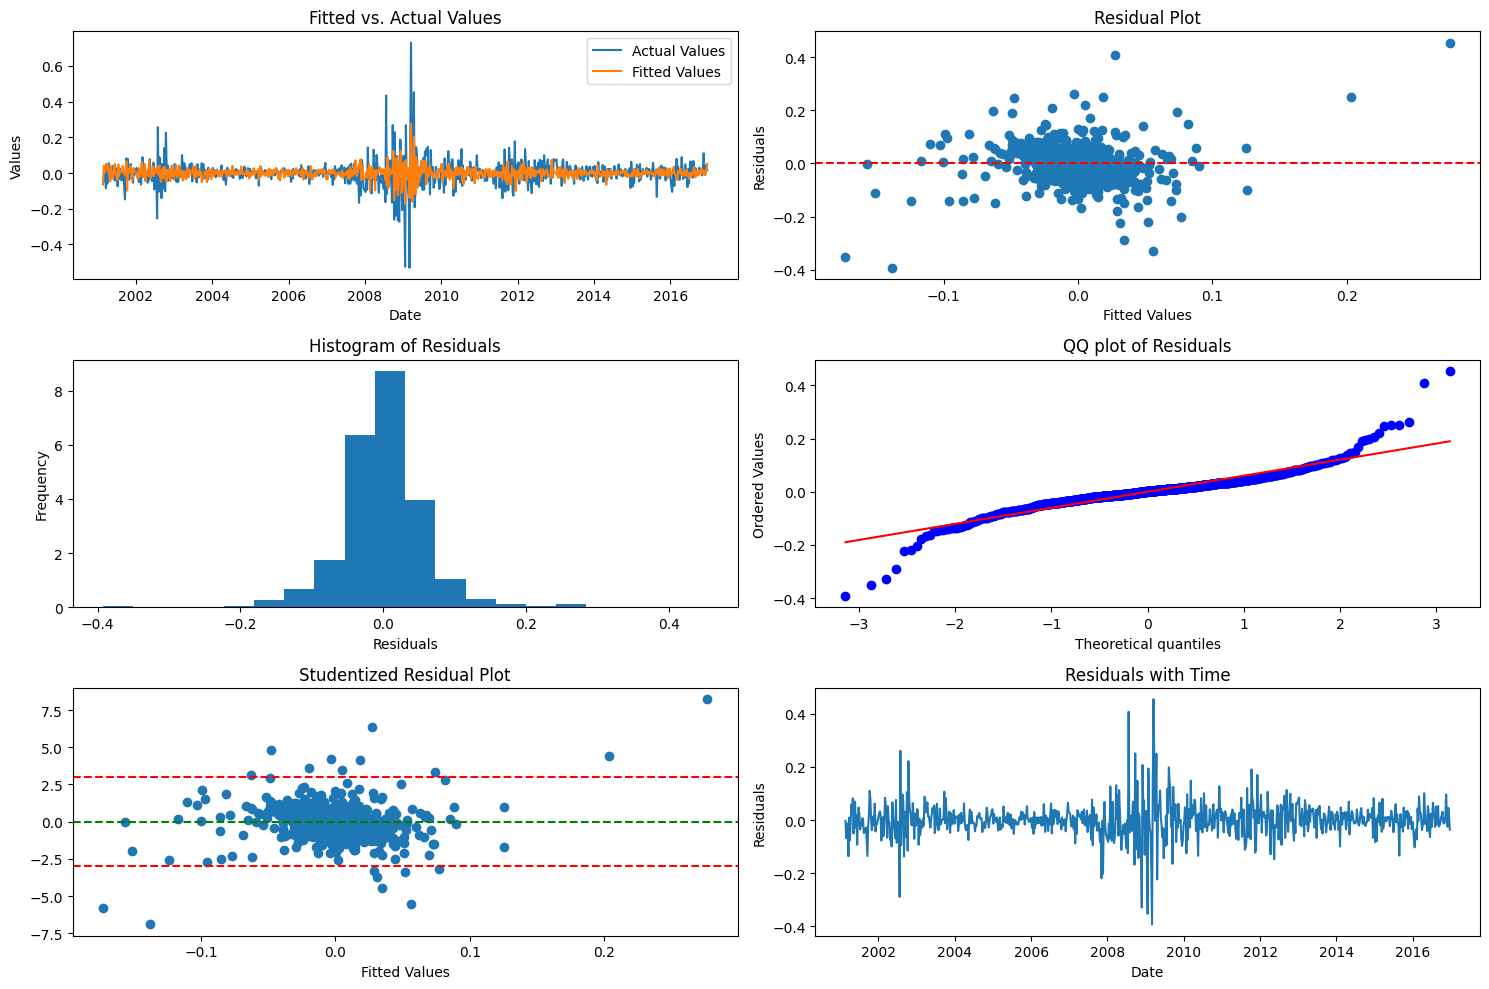

In [ ]:
# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the model summary
print(results.summary())

# Diagnostic plots
diagnostic_plots(X, y, results,dates)

In [ ]:
# new_data = df.drop(['Date','Federal Funds Rate_diff','S&P500_diff','Inflation_diff','GDP_diff','Citigroup','Bank of America','Wells Fargo','Goldman Sachs','Morgan Stanley'],axis=1)
# new_data.to_csv('out.csv', index=False)

In [ ]:
# new_data.columns

We employed both backward selection and forward selection and found the model from the backward selection to be better in terms of adjusted
${R^2}$:

Citigroup_lag1, JPMorgan.Chase_lag1, Goldman.Sachs_lag1, Morgan Stanley_lag1, Citigroup_lag2, Bank.of.America_lag2, JPMorgan Chase_lag2,Morgan.Stanley_lag2  JPMorgan.Chase_lag3    Wells.Fargo_lag3    Morgan.Stanley_lag3, S.P500_diff_lag3, Inflation_diff_lag3, Citigroup_lag4, Bank.of.America_lag4, JPMorgan.Chase_lag4, Wells.Fargo_lag4, Morgan.Stanley_lag4, Federal.Funds.Rate_diff_lag4

We used the R package `olsrr` to do the forward and backward selection.

In [ ]:
# The model from backward selection
X = df[['Citigroup_lag1', 'JPMorgan Chase_lag1', 'Goldman Sachs_lag1', 'Morgan Stanley_lag1',
        'Citigroup_lag2', 'Bank of America_lag2', 'JPMorgan Chase_lag2','Morgan Stanley_lag2',
        'JPMorgan Chase_lag3', 'Wells Fargo_lag3', 'Morgan Stanley_lag3', 'S&P500_diff_lag3',
        'Inflation_diff_lag3', 'Citigroup_lag4', 'Bank of America_lag4', 'JPMorgan Chase_lag4',
        'Wells Fargo_lag4', 'Morgan Stanley_lag4', 'Federal Funds Rate_diff_lag4']]

                            OLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     9.949
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           1.51e-26
Time:                        18:07:00   Log-Likelihood:                 1078.9
No. Observations:                 817   AIC:                            -2118.
Df Residuals:                     797   BIC:                            -2024.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

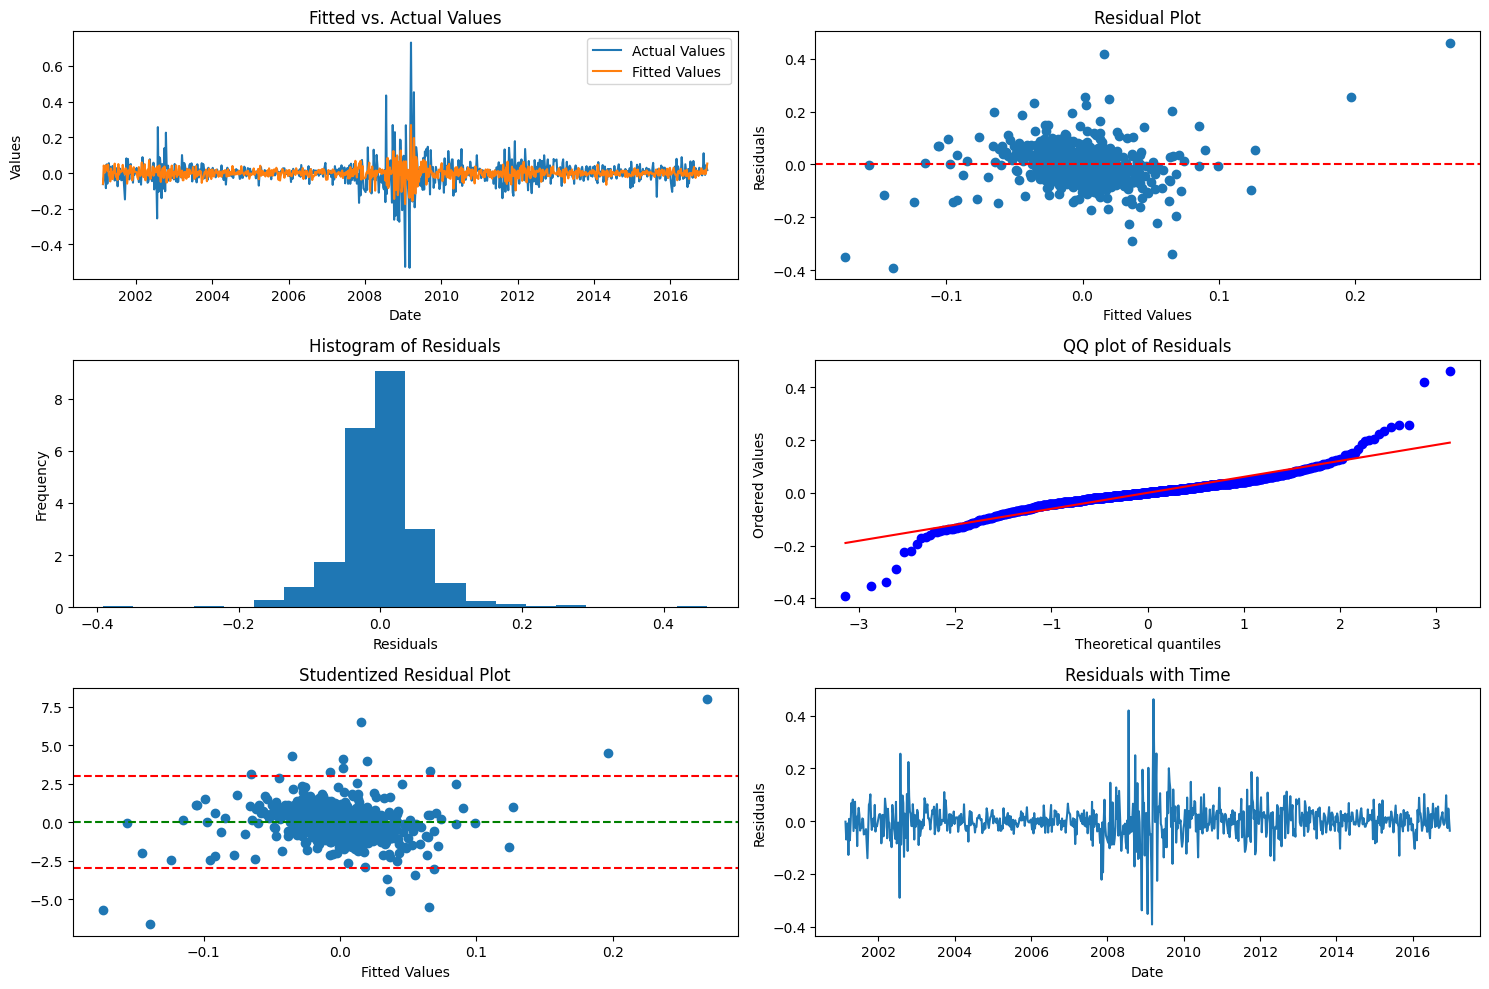

In [ ]:
# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the model summary
print(results.summary())

# Diagnostic plots
diagnostic_plots(X, y, results,dates)

### Function for checking Multicollinearity

In [ ]:
def calculate_vif(X):
    """
    Calculates Variance Inflation Factors (VIFs) for a given set of predictor variables.

    Args:
        X (pd.DataFrame): A Pandas DataFrame containing the predictor variables.

    Returns:
        pd.Series: A Pandas Series containing the VIFs for each predictor variable.
    """



    # Calculate VIFs for each predictor variable
    vif_data = {}
    # print(X)
    vif_data["feature"] = list(X.columns)
    # print(X)
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
    print(pd.DataFrame(data=vif_data))

    return vif_data

### Function for checking Autocorrelation

In [ ]:
def lljung_box_test(residuals, lags=None):
    """
    Performs the Ljung-Box test for autocorrelation in residuals.

    Args:
        residuals (array-like): Model residuals.
        lags (int or array-like, optional): The number of lags to test. If None, lags 1 to min(10,residuals.shape[0]//5) are used.
    """
    if lags is None:
      lags = min(10, len(residuals) // 5)
    lb_test = acorr_ljungbox(residuals, lags=lags)

    p_values = lb_test['lb_pvalue']

    print("Ljung-Box Test Results:")
    print("Lags:", lags)
    print("P-values:", p_values)

    alpha = 0.05
    for i, p in enumerate(p_values):
      if p < alpha:
          print(f"Lag {i+1}: Autocorrelation detected (p-value = {p:.3f})")
      else:
          print(f"Lag {i+1}: No autocorrelation detected (p-value = {p:.3f})")

    # Correlogram
    sm.graphics.tsa.plot_acf(residuals, lags=lags)
    plt.title("Correlogram of Residuals")
    plt.show()

### Function for checking Normality

In [ ]:
def test_residuals_normality(residuals):
    """
    Tests the normality of residuals using the Kolmogorov-Smirnov test.

    Args:
        residuals (array-like): The residuals from a statistical model.

    Returns:
        None. Prints the p-value and result of the test.
    """

    k, p = kstest(residuals, 'norm')  # Perform the KS test
    print(f"Kolmogorov-Smirnov test p-value: {p}")

    alpha = 0.05  # Significance level
    if p < alpha:
        print("Residuals are not normally distributed (reject null hypothesis)")
    else:
        print("Residuals are normally distributed (fail to reject null hypothesis)")

### Function for checking Heteroscedasticity

In [ ]:
def heteroscedasticity_tests(results):
    """
    Performs White test and Breusch-Pagan test for heteroscedasticity.

    Args:
        results (statsmodels.regression.linear_model.RegressionResultsWrapper):
            The results of a fitted OLS regression model.

    Returns:
        None. Prints the test results and p-values.
    """

    # White Test
    white_test = sms.het_white(results.resid, results.model.exog)
    print("White Test:")
    p_value = white_test[1]
    print(f"The p- value is {p_value}")
    if p_value < 0.05:
        print("Heteroscedasticity is present.")
    else:
        print("No evidence of heteroscedasticity.")

    # Breusch-Pagan Test
    breusch_pagan_test = sms.het_breuschpagan(results.resid, results.model.exog)
    print("\nBreusch-Pagan Test:")
    p_value = breusch_pagan_test[1]
    print(f"The p- value is {p_value}")
    if p_value < 0.05:
        print("Heteroscedasticity is present.")
    else:
        print("No evidence of heteroscedasticity.")

## Checking Assumptions

In [ ]:
def check_assumptions(model,X):
  """
    Performs all the assumption checks of regression.

    Args:
        model : contains the regression model
        X : the design matrix

    Returns:
        None. Prints the test results and p-values.
    """
  resids = model.resid
  # Multicolinearity
  print("Multicolinearity:")
  calculate_vif(X)
  print("Normality:")
  test_residuals_normality(resids)
  print("Heteroscedasticity:")
  heteroscedasticity_tests(model)
  print("Autocorrelation:")
  lljung_box_test(resids)

Multicolinearity:
                         feature       VIF
0                          const  1.020644
1                 Citigroup_lag1  2.453622
2            JPMorgan Chase_lag1  2.972090
3             Goldman Sachs_lag1  3.886328
4            Morgan Stanley_lag1  4.231785
5                 Citigroup_lag2  3.714343
6           Bank of America_lag2  3.725852
7            JPMorgan Chase_lag2  2.988500
8            Morgan Stanley_lag2  2.498294
9            JPMorgan Chase_lag3  3.193149
10              Wells Fargo_lag3  2.492580
11           Morgan Stanley_lag3  2.412393
12              S&P500_diff_lag3  2.365196
13           Inflation_diff_lag3  1.056881
14                Citigroup_lag4  3.937670
15          Bank of America_lag4  4.429869
16           JPMorgan Chase_lag4  3.628623
17              Wells Fargo_lag4  3.427749
18           Morgan Stanley_lag4  2.549536
19  Federal Funds Rate_diff_lag4  1.056413
Normality:
Kolmogorov-Smirnov test p-value: 9.978997016705835e-137
Residuals ar

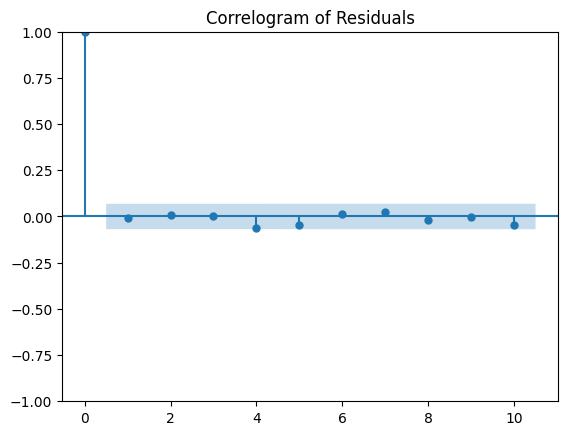

In [ ]:
check_assumptions(results, X)

We see that the residuals are heteroscedastic and the residuals are not normally distributed.
We use weighted least square to combat heteroscedasticity.

In [ ]:
def partial_residual_plot(model, X, col,col_name):
    """
    Creates a partial residual plot for a specific column not included in the model.

    Args:
        model: The fitted OLS model.
        X: The independent variables (DataFrame).
        col: The data of the column for which to plot the partial residual.
        col_name: The name of the column for the plot title.
    """
    # Residuals
    residuals = model.resid

    # Removing the effect of X from col
    new_mod = sm.OLS(col,X)
    new_res = new_mod.fit()

    partial_residuals = new_res.resid

    plt.figure(figsize=(8, 6))
    plt.scatter(residuals, partial_residuals, alpha = 0.5)
    plt.xlabel(col_name)
    plt.ylabel("Partial Residuals")
    plt.title(f"Partial Residual Plot for {col_name}")

    plt.axhline(y=0, color='red', linestyle='--')
    plt.show()
    print(f"The correlation between the residuals and {col_name} is {np.corrcoef(residuals,partial_residuals)[0][1]}")


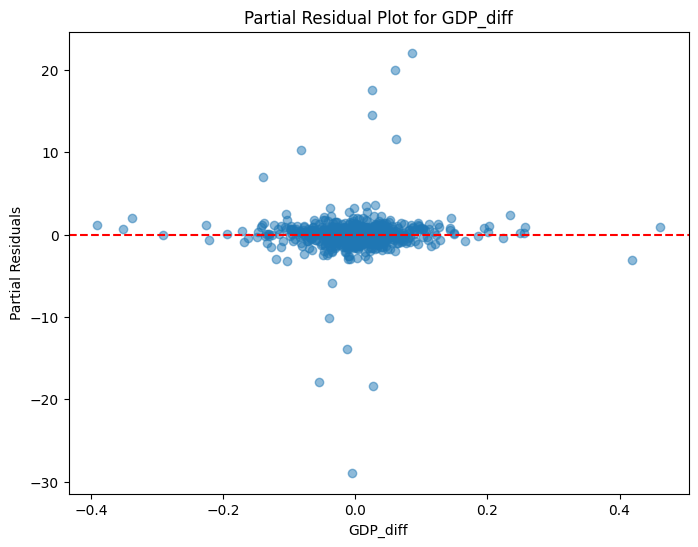

The correlation between the residuals and GDP_diff is 0.03426466657250328



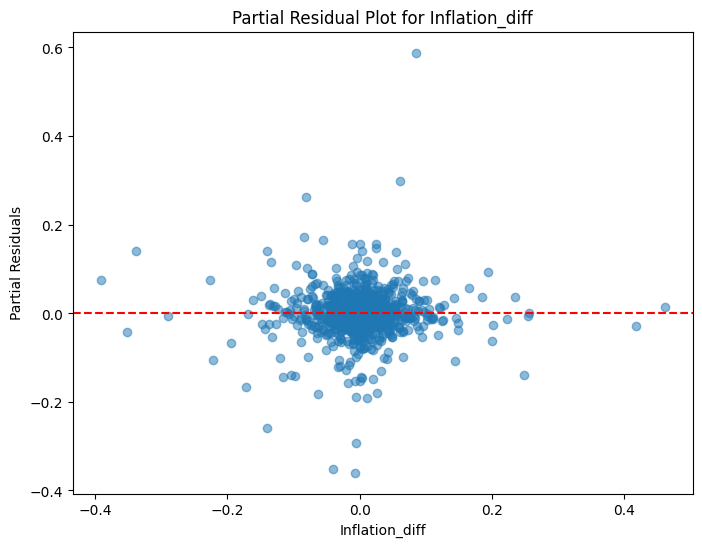

The correlation between the residuals and Inflation_diff is 0.02234149343009566



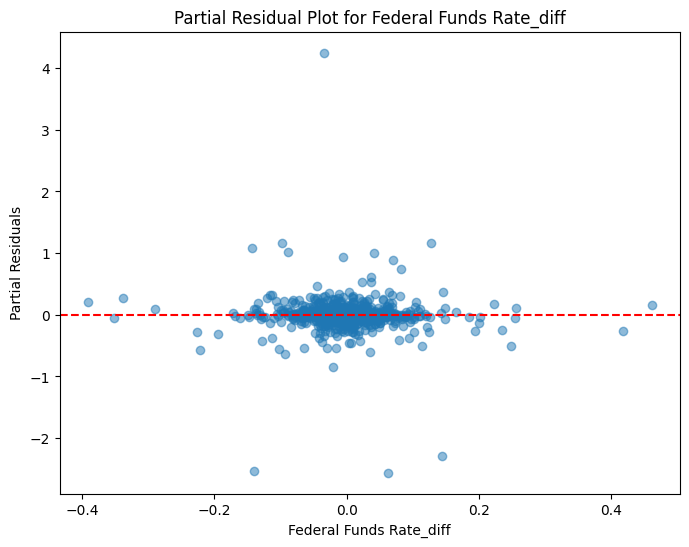

The correlation between the residuals and Federal Funds Rate_diff is -0.03950554522462821



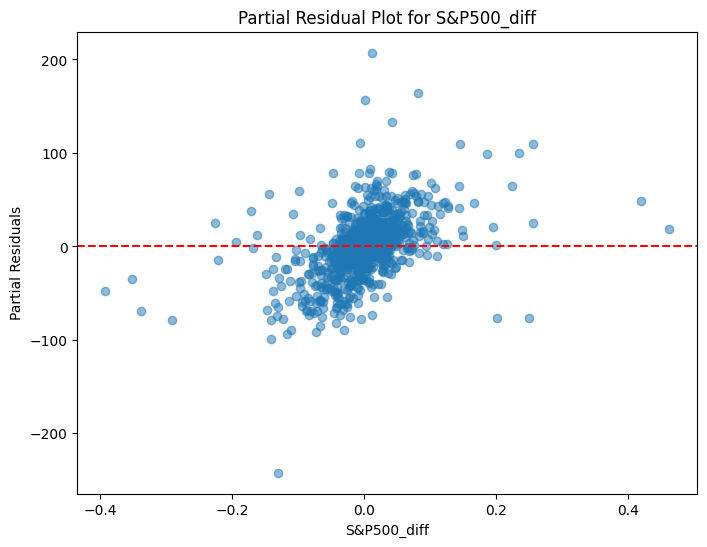

The correlation between the residuals and S&P500_diff is 0.48100336691000484



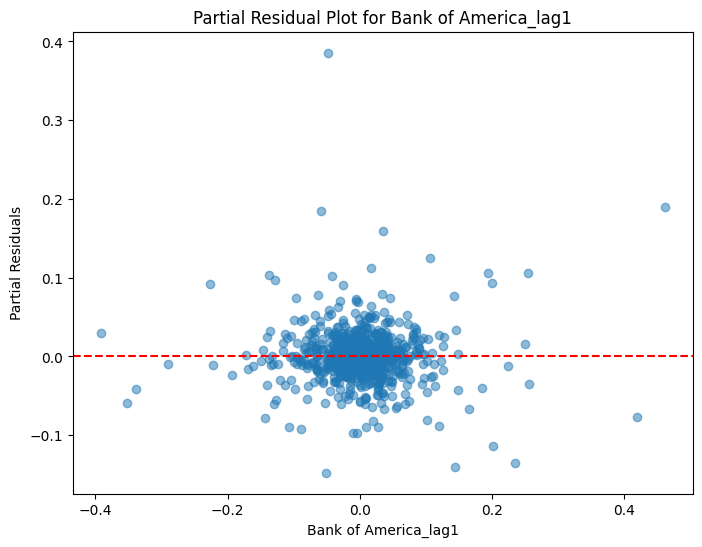

The correlation between the residuals and Bank of America_lag1 is 0.0009408194169335797



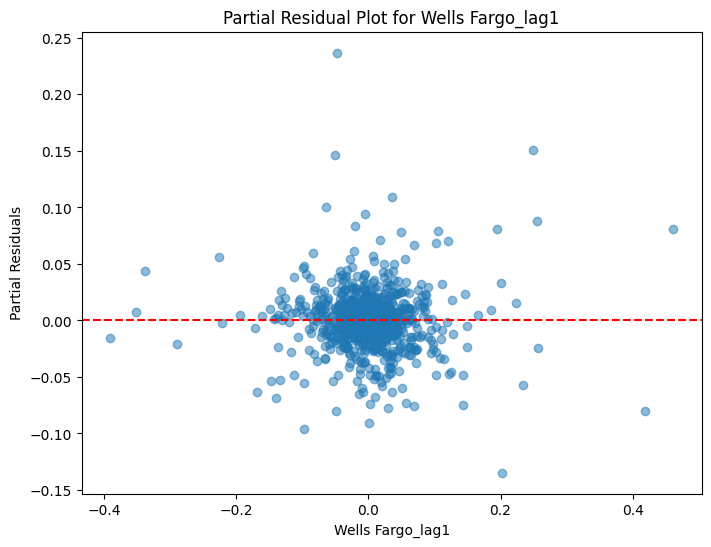

The correlation between the residuals and Wells Fargo_lag1 is -0.019805678333543807



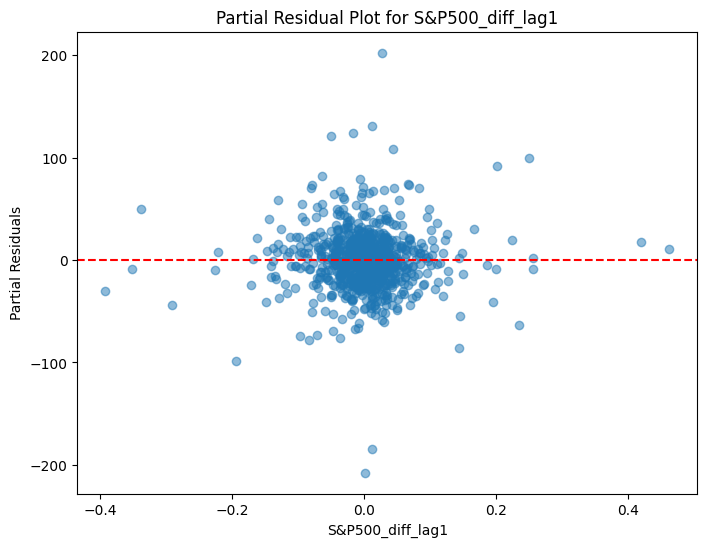

The correlation between the residuals and S&P500_diff_lag1 is 0.009846242653592798



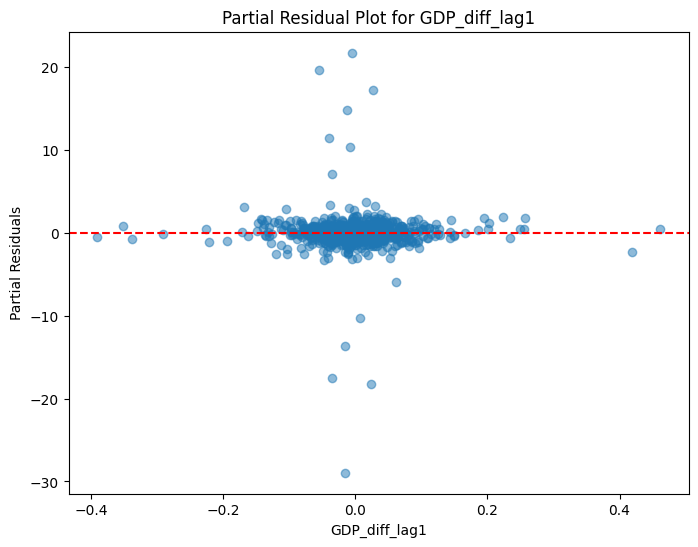

The correlation between the residuals and GDP_diff_lag1 is -0.009106757482871656



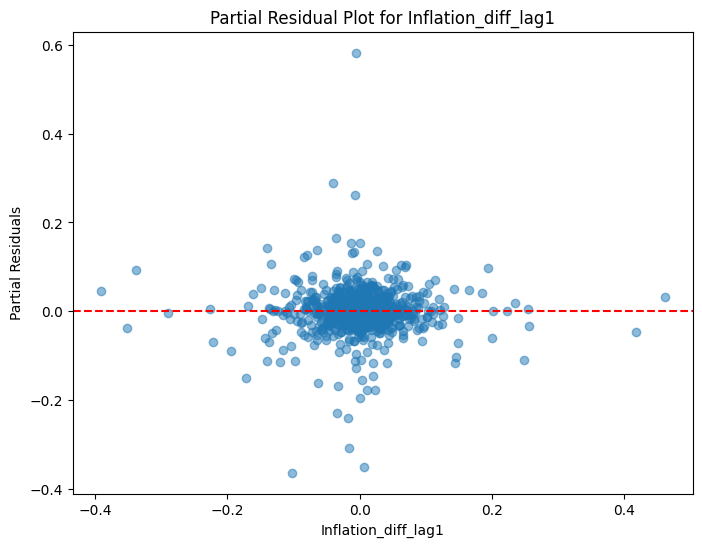

The correlation between the residuals and Inflation_diff_lag1 is 0.010333885848799327



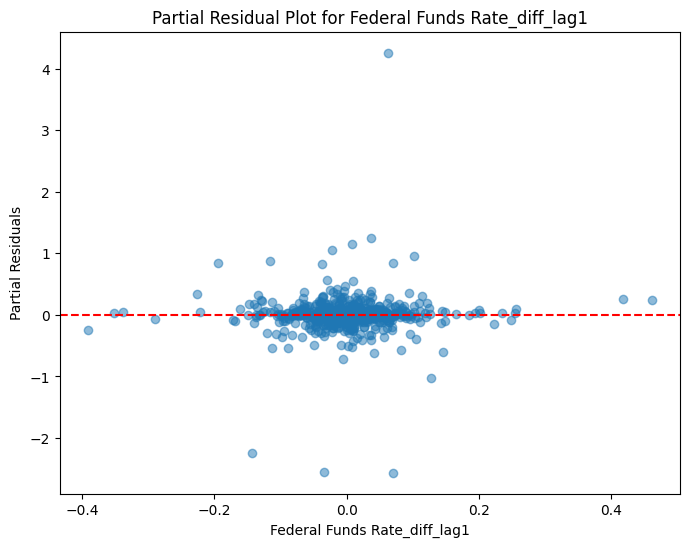

The correlation between the residuals and Federal Funds Rate_diff_lag1 is 0.031745641511590525



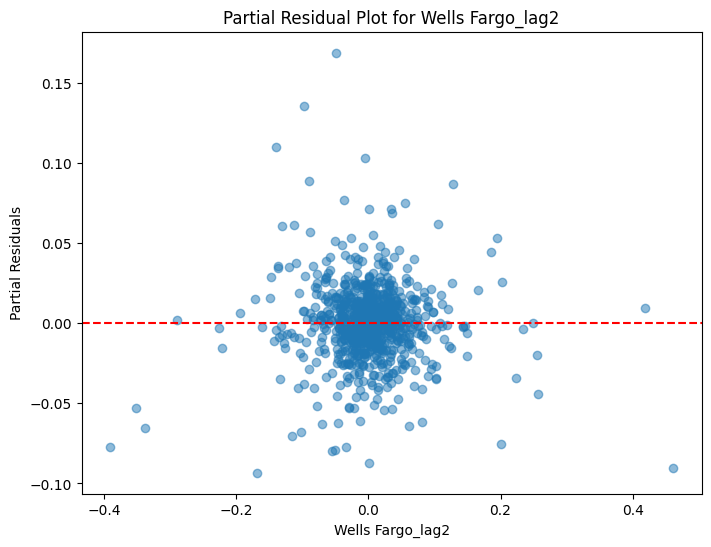

The correlation between the residuals and Wells Fargo_lag2 is -0.00732707533200836



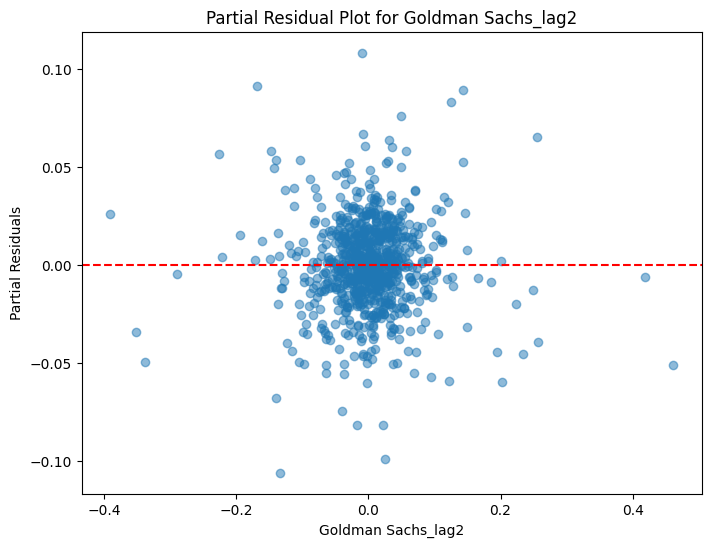

The correlation between the residuals and Goldman Sachs_lag2 is -0.006438920536666434



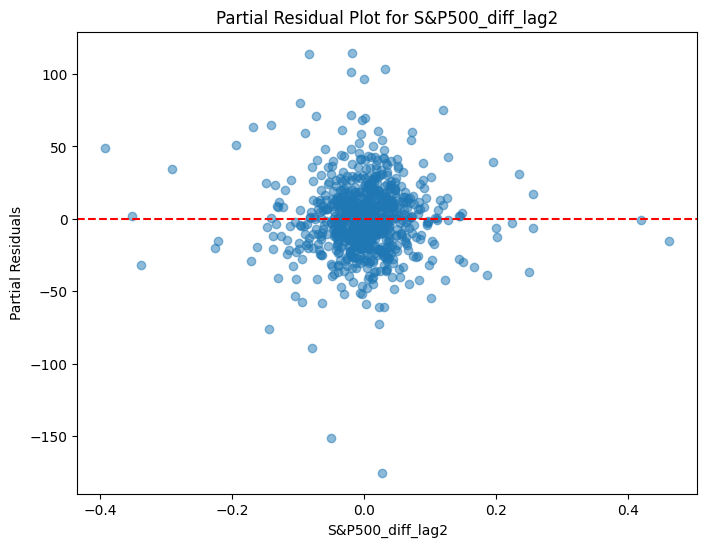

The correlation between the residuals and S&P500_diff_lag2 is -0.0035072918620568244



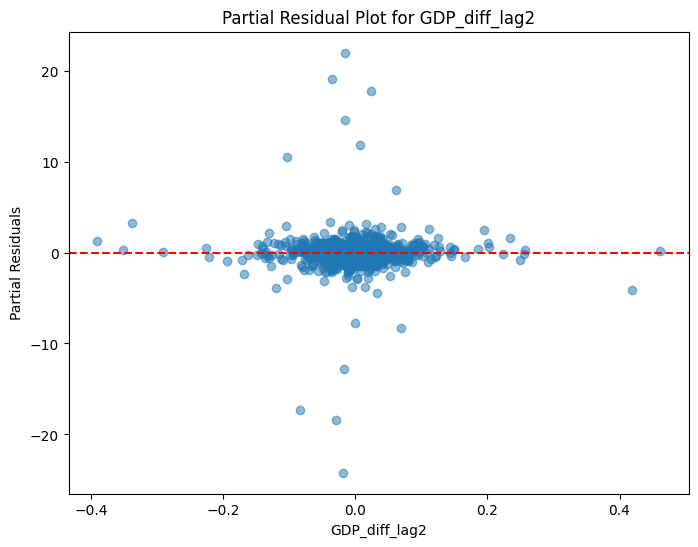

The correlation between the residuals and GDP_diff_lag2 is 0.0014994401361084857



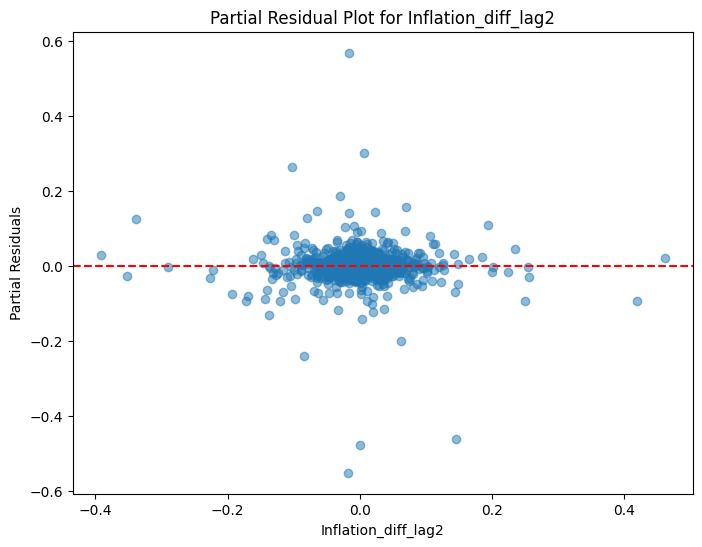

The correlation between the residuals and Inflation_diff_lag2 is -0.0333773499508381



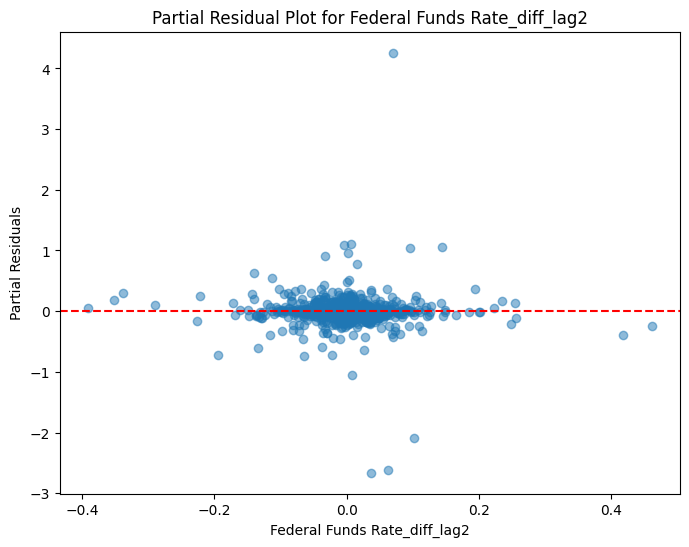

The correlation between the residuals and Federal Funds Rate_diff_lag2 is -0.036391600412873835



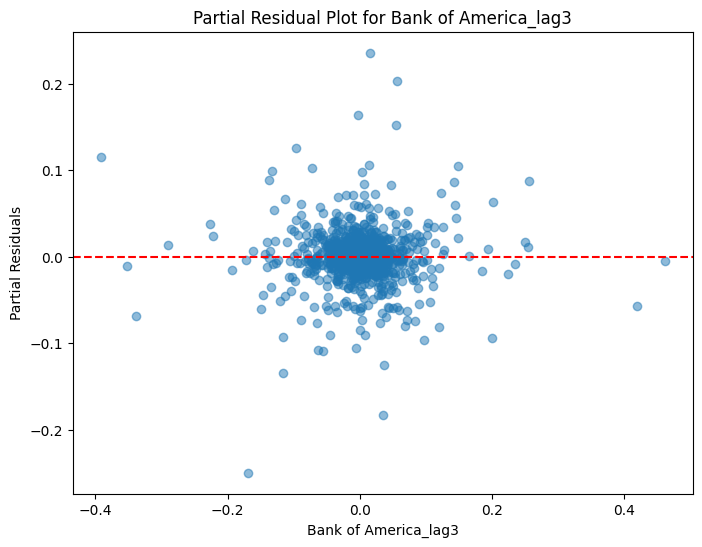

The correlation between the residuals and Bank of America_lag3 is 0.005958722957975124



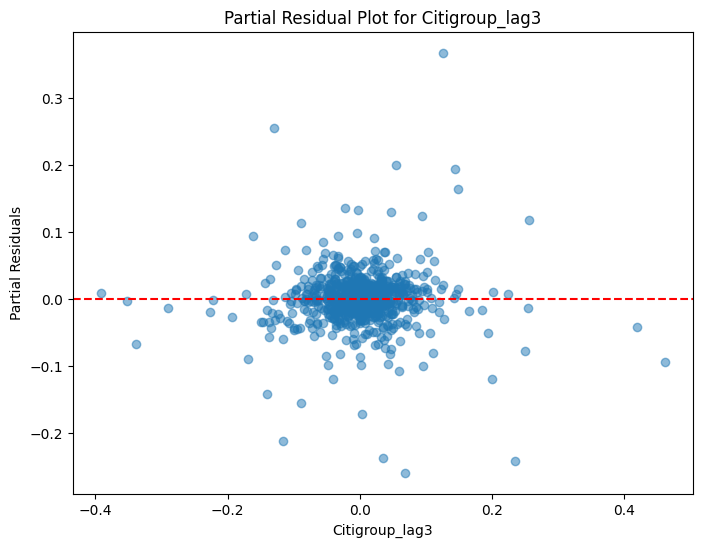

The correlation between the residuals and Citigroup_lag3 is 0.017009291458801652



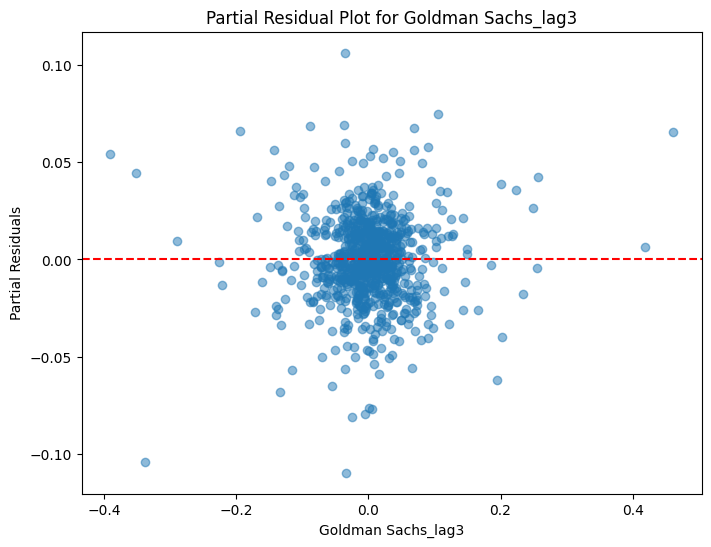

The correlation between the residuals and Goldman Sachs_lag3 is 0.023896456562724187



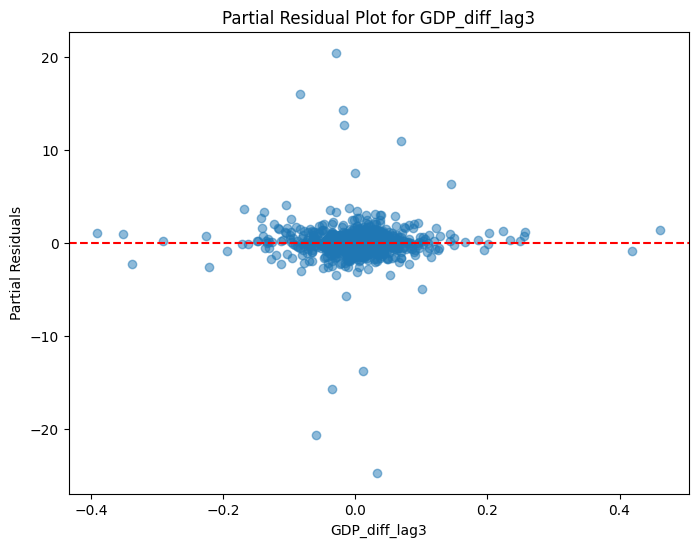

The correlation between the residuals and GDP_diff_lag3 is -0.004348045185002845



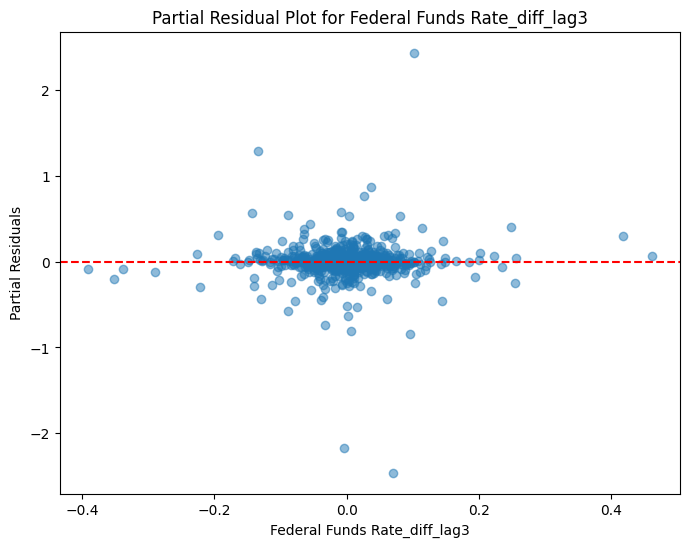

The correlation between the residuals and Federal Funds Rate_diff_lag3 is 0.028563209147991



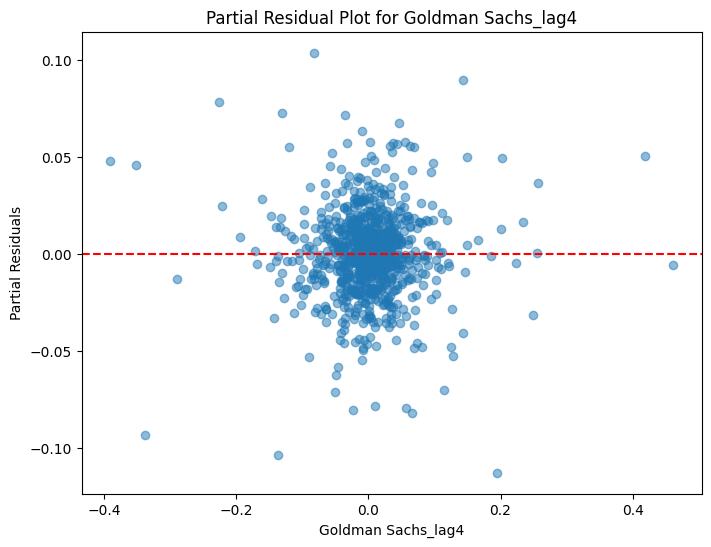

The correlation between the residuals and Goldman Sachs_lag4 is 0.007634341937169789



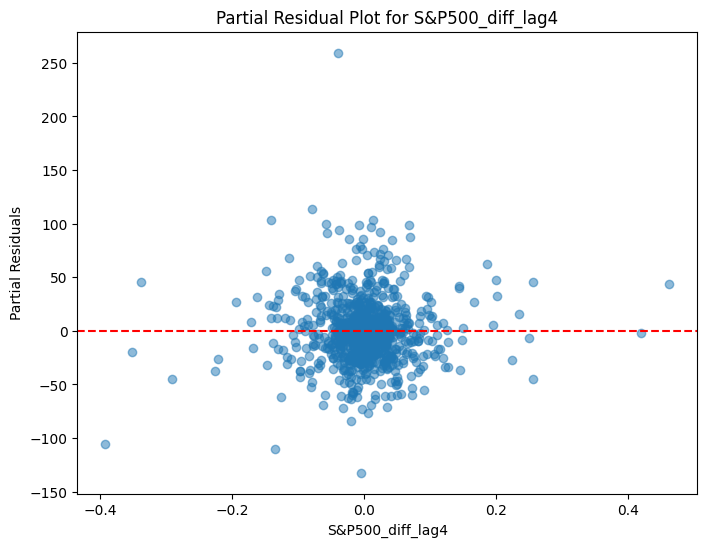

The correlation between the residuals and S&P500_diff_lag4 is 0.012275669510164003



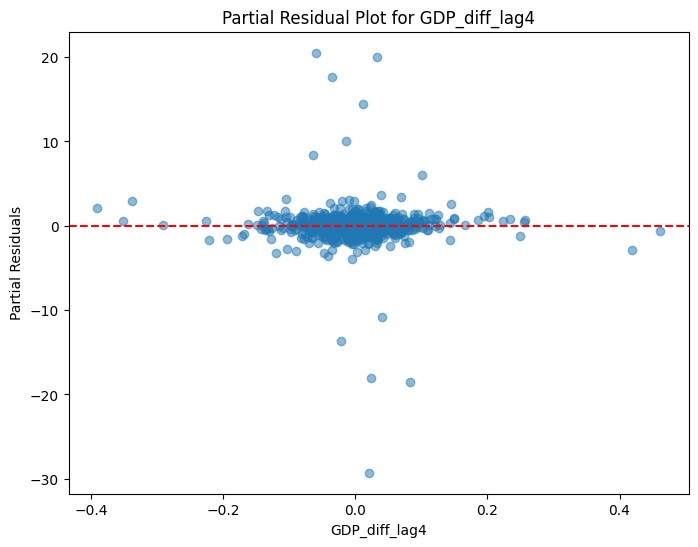

The correlation between the residuals and GDP_diff_lag4 is -0.025914292851057192



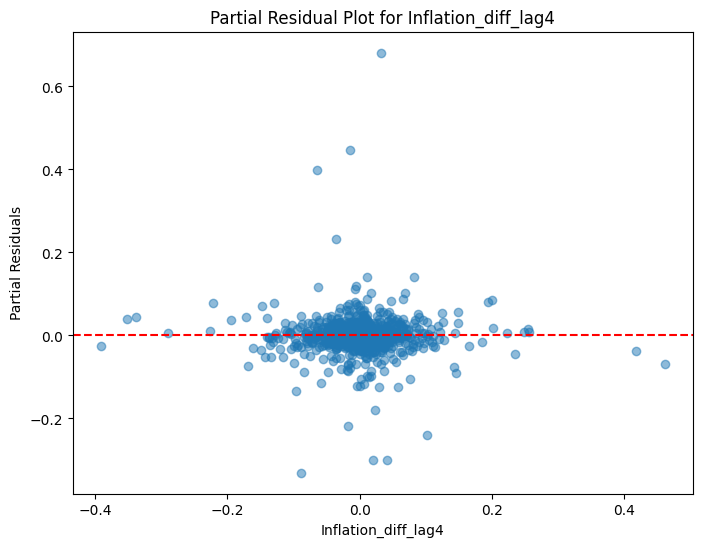

The correlation between the residuals and Inflation_diff_lag4 is -0.014910052407763417


In [ ]:
columns_in_model = ['Citigroup_lag1', 'JPMorgan Chase_lag1', 'Goldman Sachs_lag1', 'Morgan Stanley_lag1',
        'Citigroup_lag2', 'Bank of America_lag2', 'JPMorgan Chase_lag2','Morgan Stanley_lag2',
        'JPMorgan Chase_lag3', 'Wells Fargo_lag3', 'Morgan Stanley_lag3', 'S&P500_diff_lag3',
        'Inflation_diff_lag3', 'Citigroup_lag4', 'Bank of America_lag4', 'JPMorgan Chase_lag4',
        'Wells Fargo_lag4', 'Morgan Stanley_lag4', 'Federal Funds Rate_diff_lag4']
y_column = ['Date']

for i in df.columns:
  if i not in columns_in_model + y_column + bank_columns:
    col = df[i]
    print()
    partial_residual_plot(results, X, col,i)

In [ ]:
def plot_residuals_vs_independent(model, X, y):
    """
    Generates plots of residuals against independent variable values.

    Args:
        model: The fitted OLS model.
        X: The independent variables (DataFrame).
        y: The dependent variable (Series).
    """

    residuals = model.resid

    for col in X.columns:
      if col != 'const':
        plt.figure(figsize=(8, 6))
        plt.scatter(X[col], residuals)
        plt.xlabel(col)
        plt.ylabel("Residuals")
        plt.title(f"Residuals vs. {col}")
        plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
        plt.show()


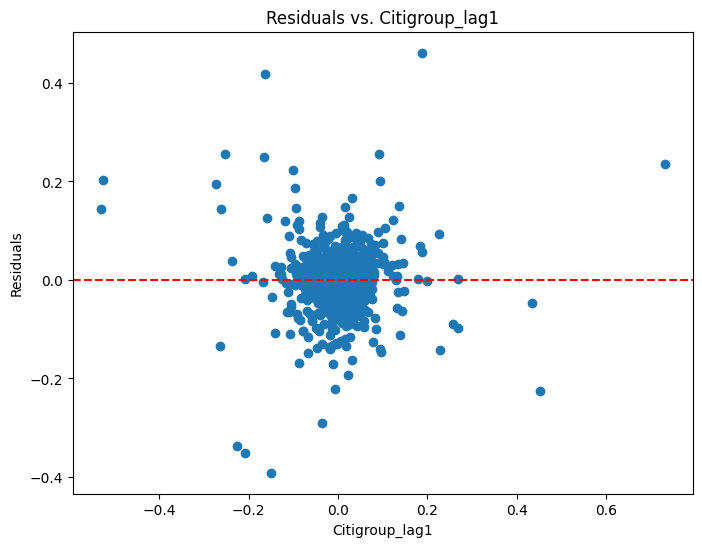

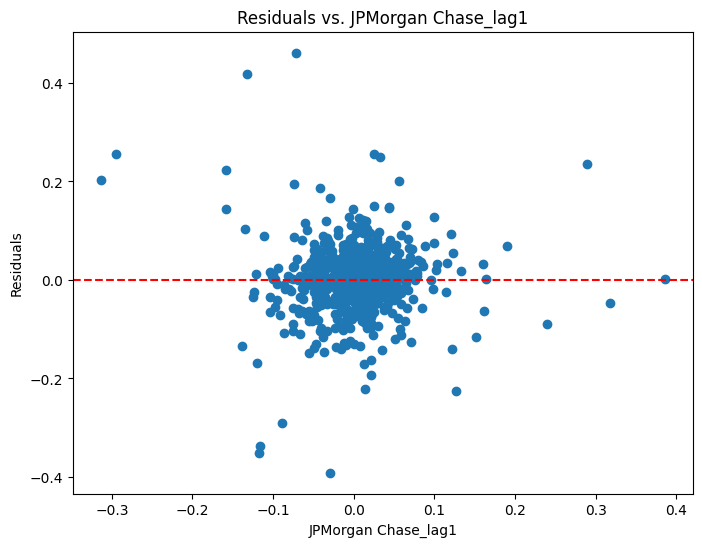

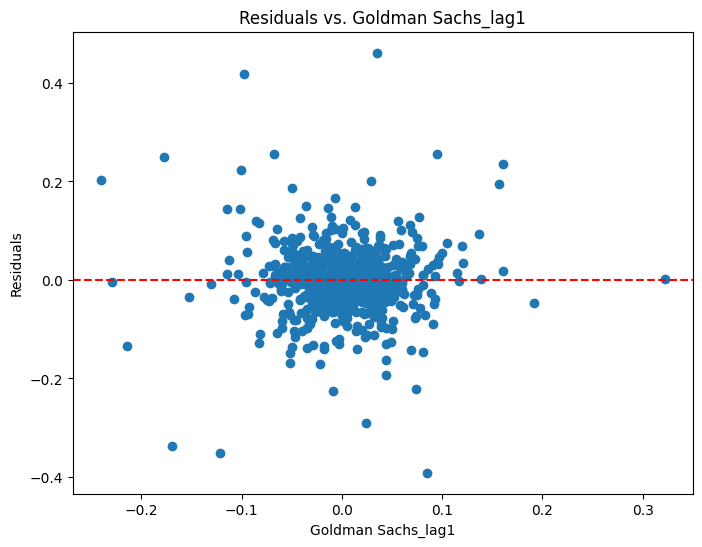

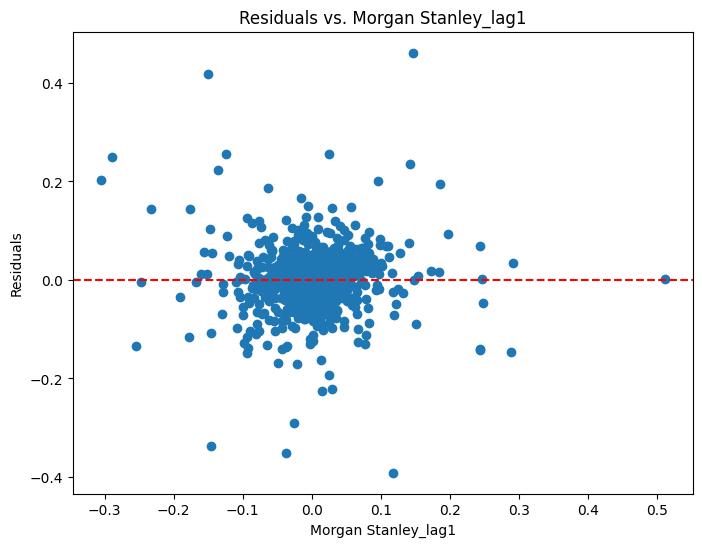

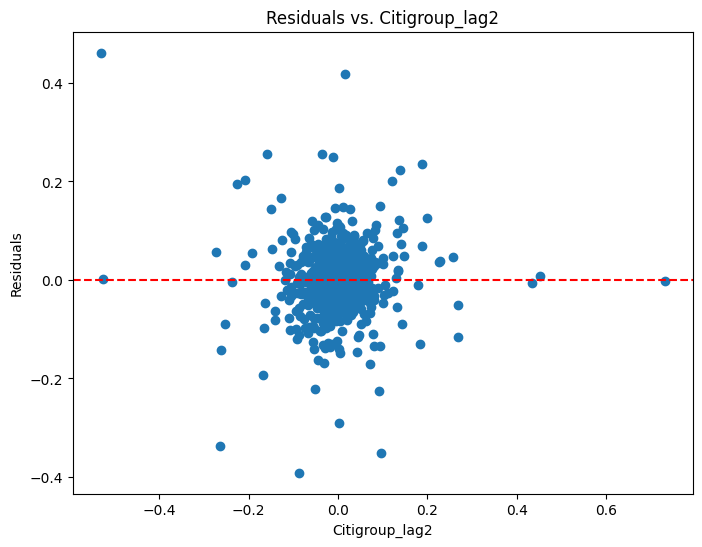

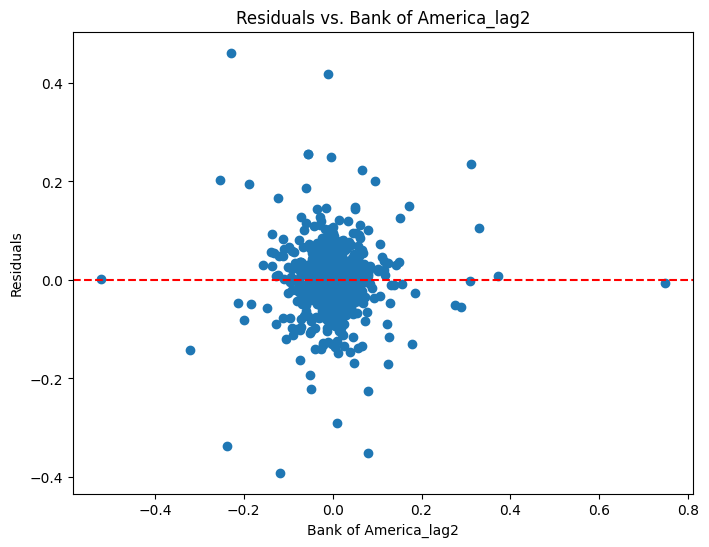

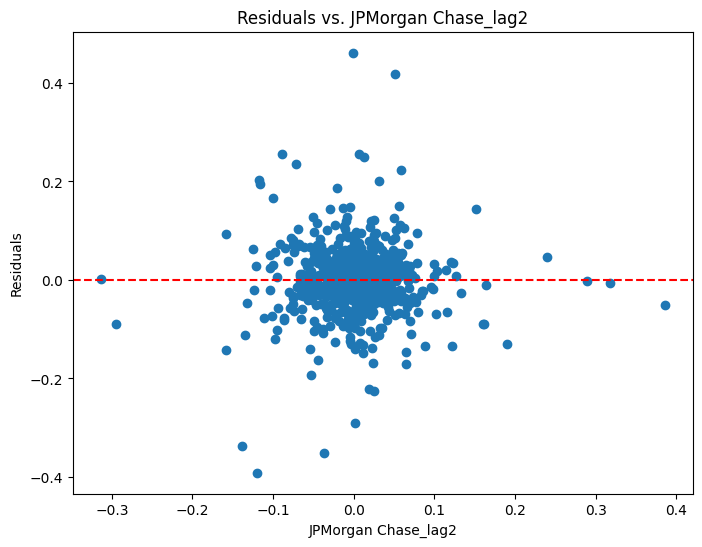

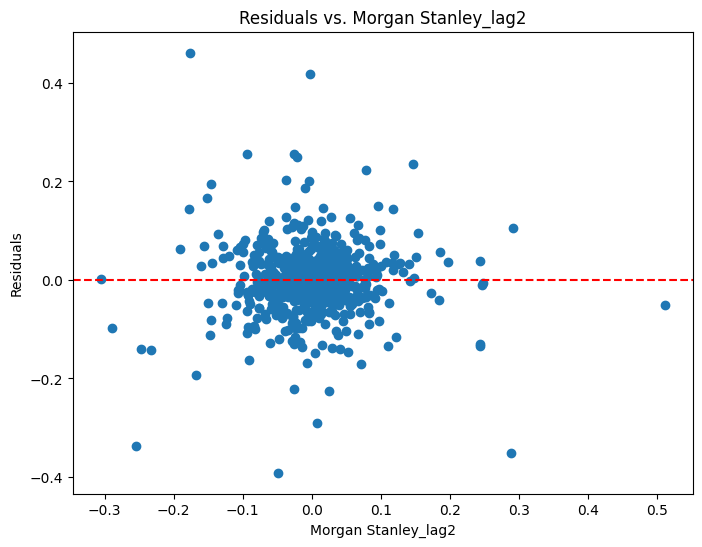

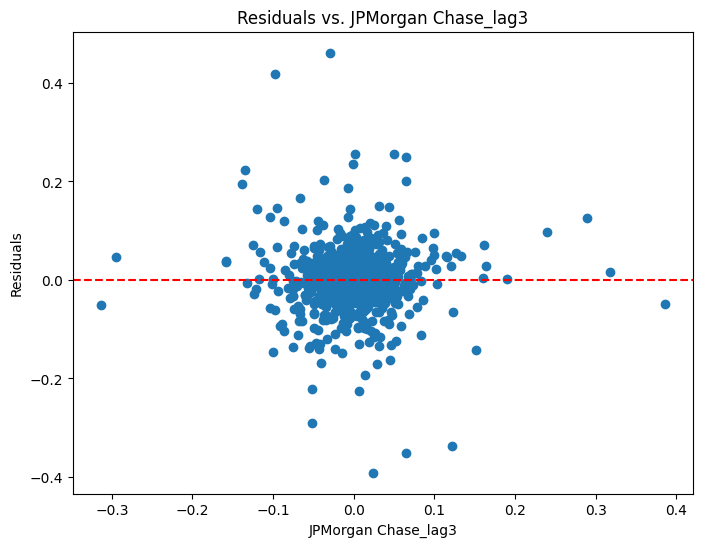

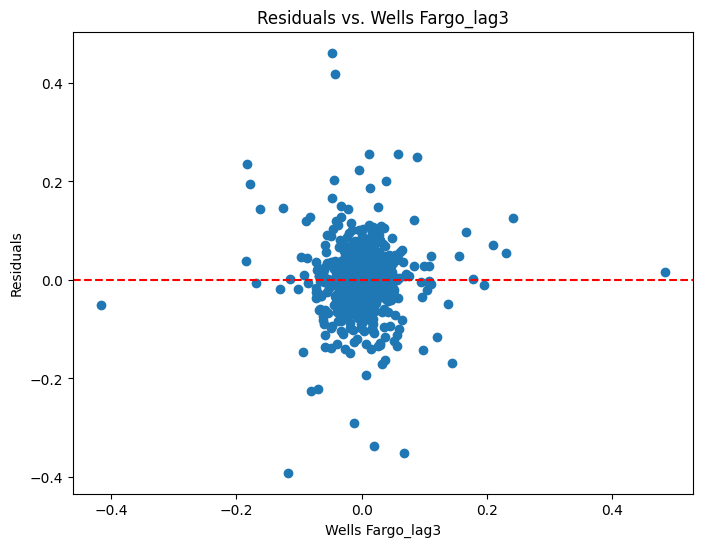

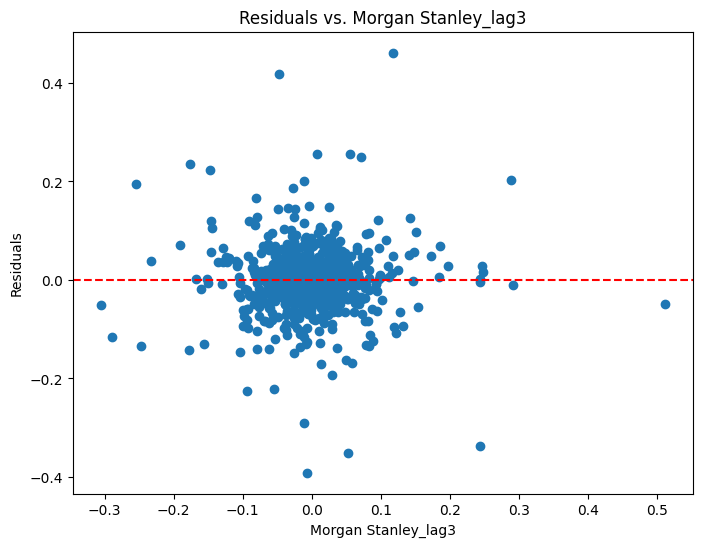

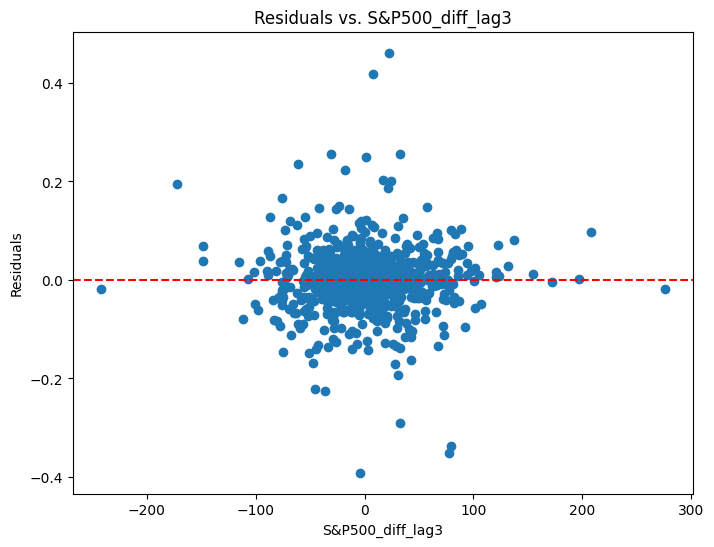

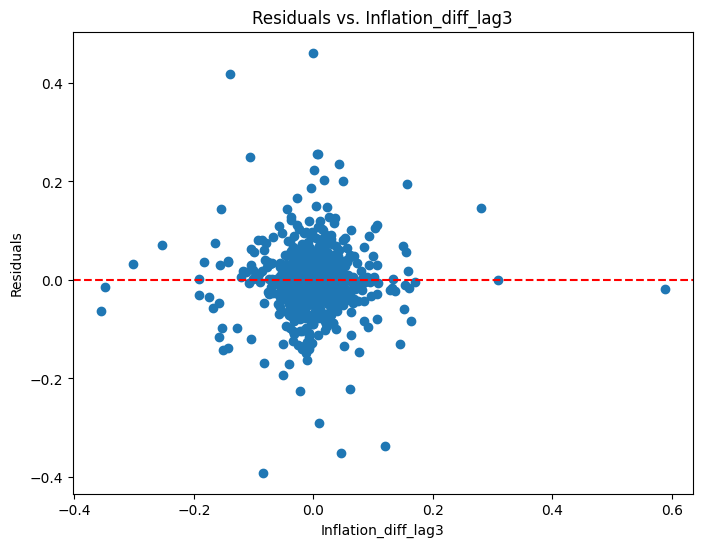

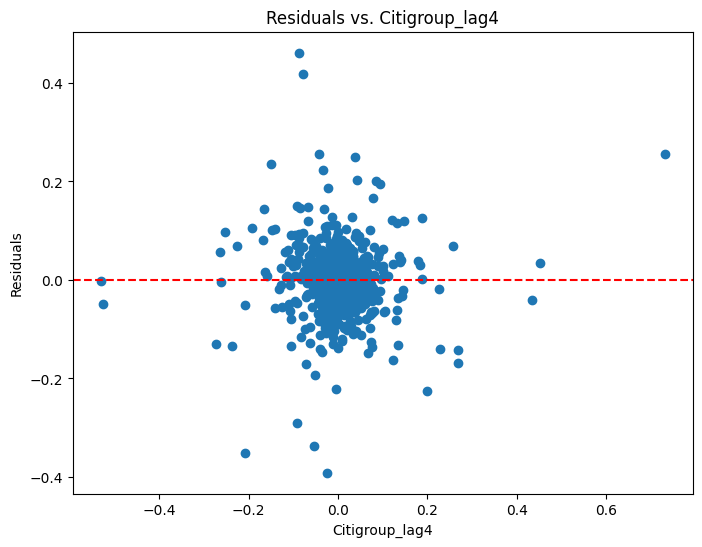

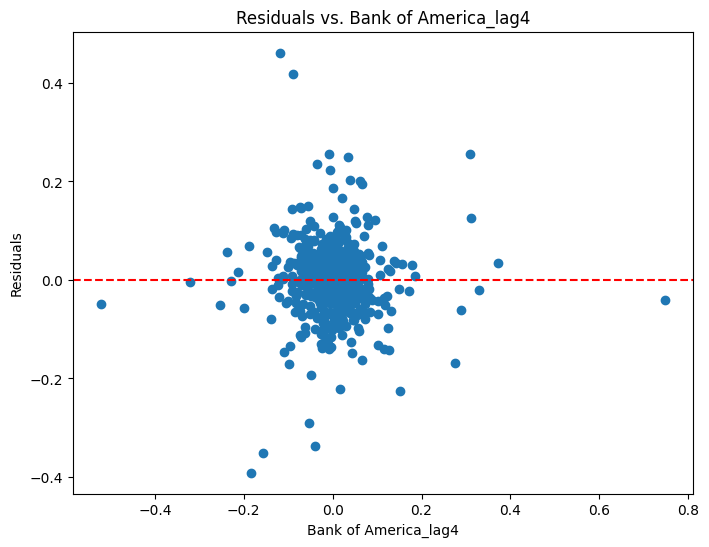

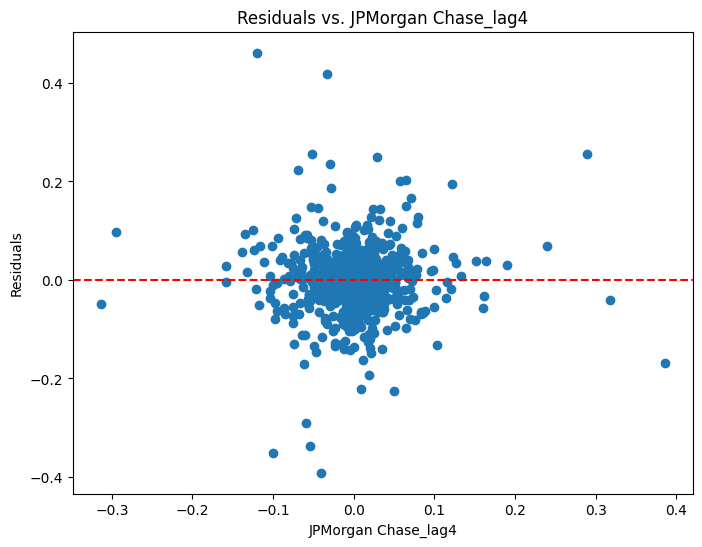

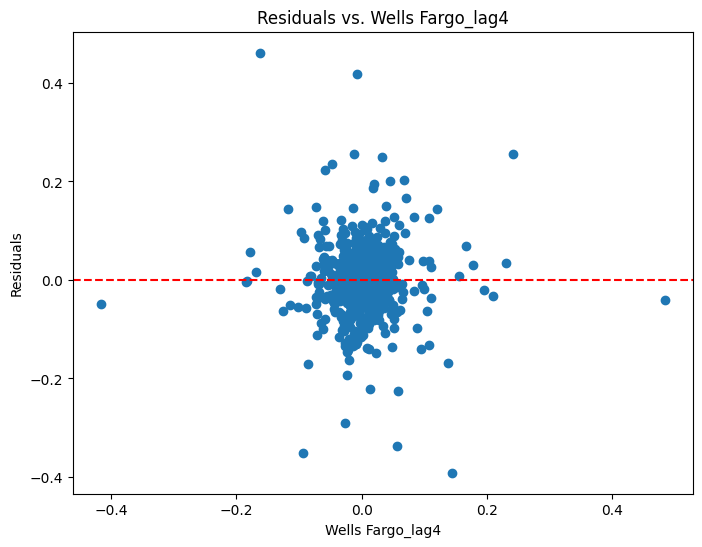

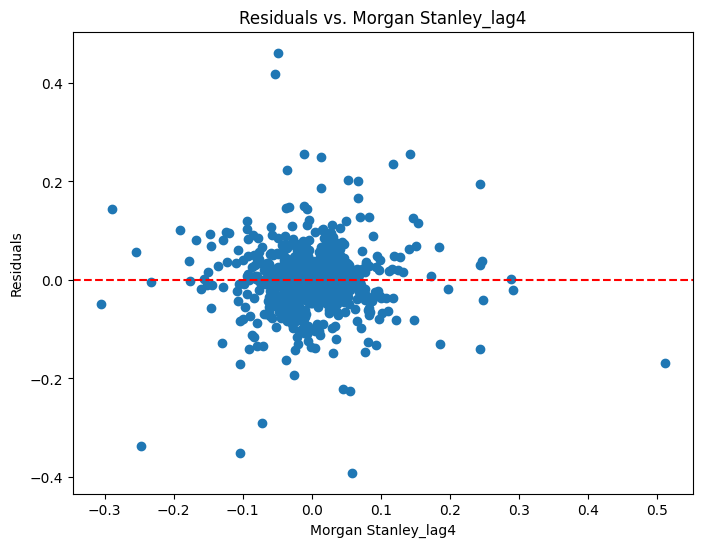

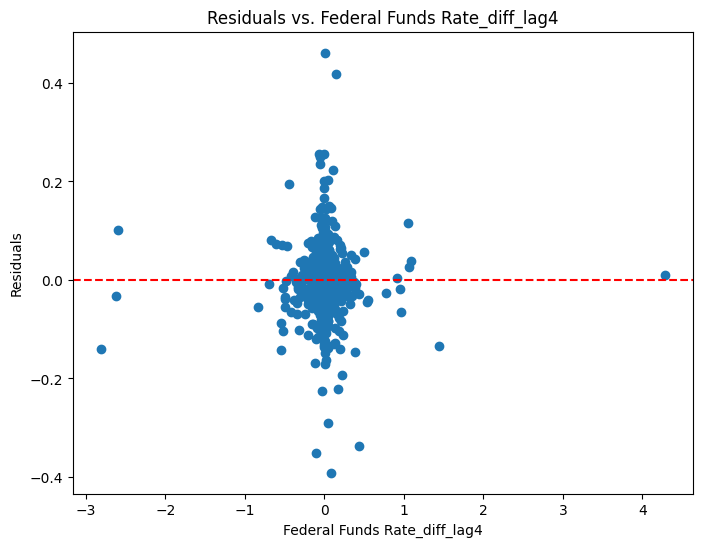

In [ ]:
plot_residuals_vs_independent(results, X, y)

From this we see that S&P500 is highly correlated with the residuals, but we cannot add that as it contains the data of the data we look to predict so we will not have that data at the time of our prediction.

Now we look to plot the Leverage values, DFFITS and the Cook's Distance for the model.

In [ ]:
# Function for Plotting diagnostics
def plot_influence_diagnostics(model, dates, dffits_thresh=2, cooks_thresh=4/model.nobs):
    """
    Plots DFFITS, Leverage, and Cook's Distance against Dates, highlighting influential observations.

    Parameters:
        model: A fitted regression model
        dates: List or array of dates corresponding to each observation.
        dffits_thresh: Threshold for DFFITS (default: 2).
        cooks_thresh: Threshold for Cook's Distance (default: 4/n).

    Returns:
        influential_points: Dictionary containing dates where values exceed thresholds for:
            - 'DFFITS'
            - 'Leverage'
            - 'Cook's Distance'
    """

    # Extract influence measures
    influence = model.get_influence()
    leverage = influence.hat_matrix_diag  # Leverage values
    dffits = influence.dffits[0]  # DFFITS values
    cooks_d = influence.cooks_distance[0]  # Cook's Distance values

    # Compute leverage cutoff (2p/n rule)
    num_obs, num_params = model.df_model + model.df_resid + 1, model.df_model + 1
    leverage_cutoff = 2 * num_params / num_obs

    # Identify influential points
    dffits_mask = np.abs(dffits) > dffits_thresh
    leverage_mask = leverage > leverage_cutoff
    cooks_mask = cooks_d > cooks_thresh

    # Store dates exceeding thresholds
    influential_points = {
        "DFFITS": dates[dffits_mask].tolist(),
        "Leverage": dates[leverage_mask].tolist(),
        "Cook's Distance": dates[cooks_mask].tolist(),
    }

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # --- DFFITS Plot ---
    axes[0].scatter(dates, dffits, color='b', label='DFFITS', alpha=0.7)
    axes[0].axhline(dffits_thresh, color='r', linestyle='dashed', label=f'Threshold ±{dffits_thresh}')
    axes[0].axhline(-dffits_thresh, color='r', linestyle='dashed')
    axes[0].set_ylabel("DFFITS")
    axes[0].set_title("DFFITS vs. Dates")
    axes[0].legend()

    # --- Leverage Plot ---
    axes[1].scatter(dates, leverage, color='g', label='Leverage', alpha=0.7)
    axes[1].axhline(leverage_cutoff, color='r', linestyle='dashed', label=f'Threshold: {leverage_cutoff:.4f}')
    axes[1].set_ylabel("Leverage")
    axes[1].set_title("Leverage vs. Dates")
    axes[1].legend()

    # --- Cook's Distance Plot ---
    axes[2].scatter(dates, cooks_d, color='purple', label="Cook's Distance", alpha=0.7)
    axes[2].axhline(cooks_thresh, color='r', linestyle='dashed', label=f'Threshold: {cooks_thresh:.4f}')
    axes[2].set_ylabel("Cook's Distance")
    axes[2].set_title("Cook's Distance vs. Dates")
    axes[2].legend()

    # Formatting
    plt.xticks(rotation=45)
    plt.xlabel("Dates")
    plt.tight_layout()
    plt.show()

    return influential_points

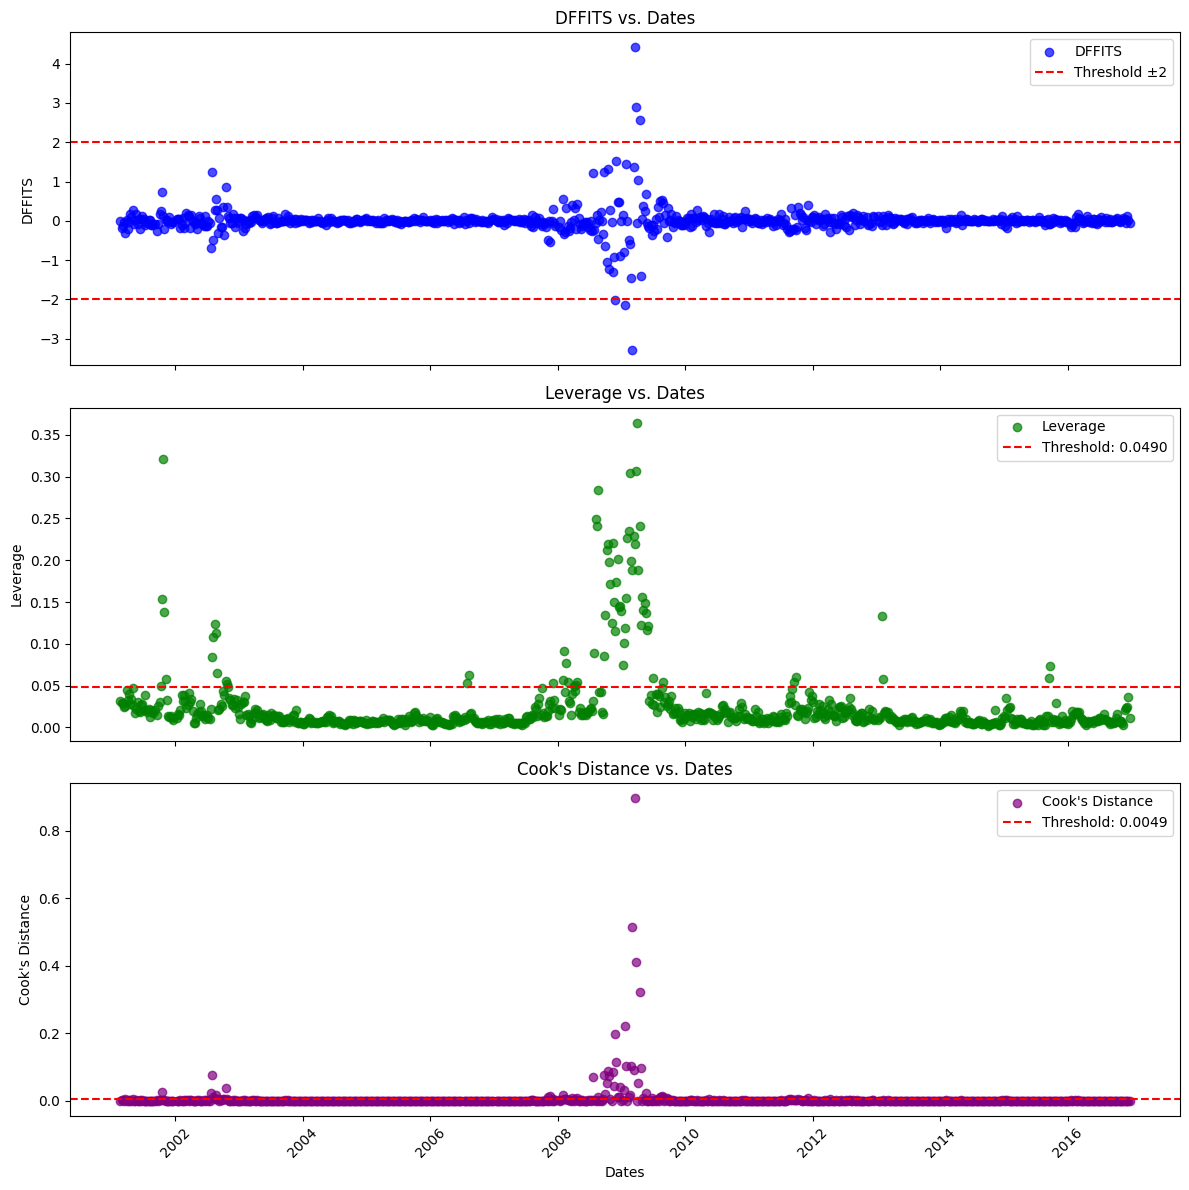

In [ ]:
influential_points = plot_influence_diagnostics(results, dates)

In [ ]:
influential_points

{'DFFITS': [Timestamp('2008-11-25 00:00:00'),
  Timestamp('2009-01-20 00:00:00'),
  Timestamp('2009-03-03 00:00:00'),
  Timestamp('2009-03-17 00:00:00'),
  Timestamp('2009-03-24 00:00:00'),
  Timestamp('2009-04-14 00:00:00')],
 'Leverage': [Timestamp('2001-10-09 00:00:00'),
  Timestamp('2001-10-16 00:00:00'),
  Timestamp('2001-10-23 00:00:00'),
  Timestamp('2001-10-30 00:00:00'),
  Timestamp('2001-11-06 00:00:00'),
  Timestamp('2002-07-30 00:00:00'),
  Timestamp('2002-08-06 00:00:00'),
  Timestamp('2002-08-13 00:00:00'),
  Timestamp('2002-08-20 00:00:00'),
  Timestamp('2002-08-27 00:00:00'),
  Timestamp('2002-10-15 00:00:00'),
  Timestamp('2002-10-22 00:00:00'),
  Timestamp('2006-08-01 00:00:00'),
  Timestamp('2006-08-08 00:00:00'),
  Timestamp('2007-12-04 00:00:00'),
  Timestamp('2008-01-29 00:00:00'),
  Timestamp('2008-02-05 00:00:00'),
  Timestamp('2008-02-19 00:00:00'),
  Timestamp('2008-02-26 00:00:00'),
  Timestamp('2008-04-01 00:00:00'),
  Timestamp('2008-04-15 00:00:00'),
  Tim

To handle heteroscedasticity, we may use the **Huber White Standard Error** for estimating the standard errors. We cannot use fgls as the sample size is small. But we will try anyways.

For the non-normality issue we look to transform the y value using Box-Cox and again check for stationarity and see if it improves.

In [ ]:
# Transforming the y variable
y_transformed, best_lambda = stats.yeojohnson(y)

Text(0, 0.5, 'Transformed y')

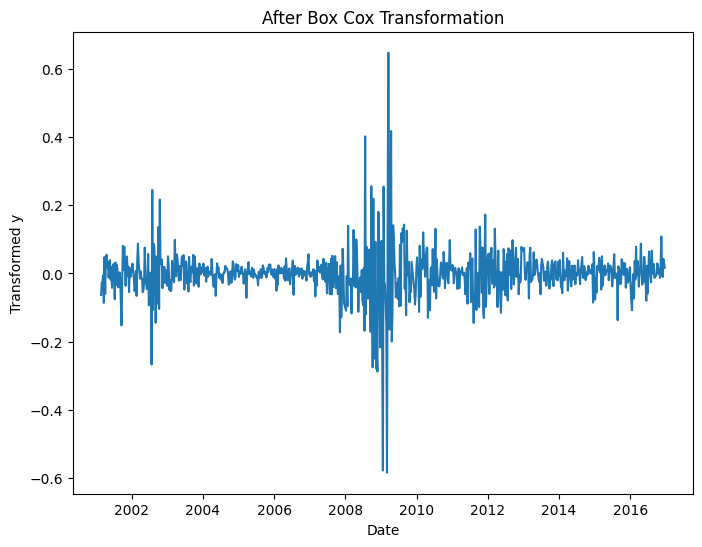

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(dates,y_transformed)
plt.title("After Box Cox Transformation")
plt.xlabel("Date")
plt.ylabel("Transformed y")

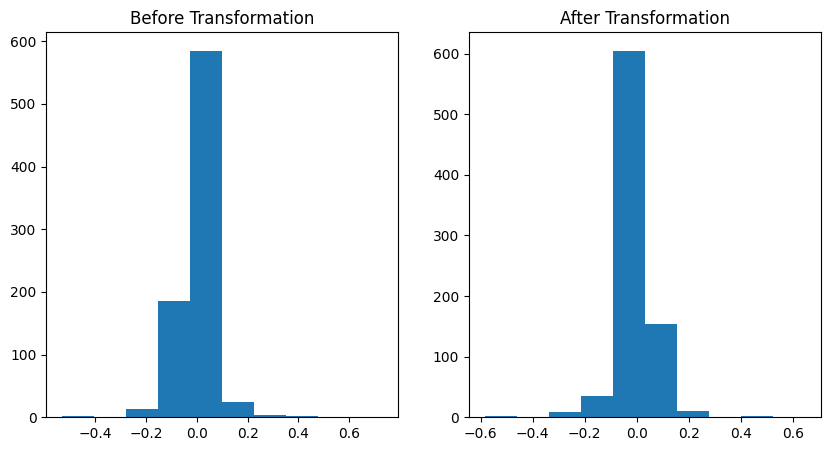

In [ ]:
# -- plotting the before and after transformation--
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[1].hist(y_transformed,label="")
ax[1].set_title("After Transformation")

ax[0].set_title("Before Transformation")
ax[0].hist(y,label="Before Transformation")
plt.show()

In [ ]:
# Checking for stationarity of y_transformed
if adfuller(y_transformed)[1] < 0.05:
  print(f"The transformed y is stationary")
else:
  print(f"The transformed y is not stationary")

The transformed y is stationary


In [ ]:
# Applying the model on the transformed y
model_t = sm.OLS(y_transformed, X)
results_t = model_t.fit()

In [ ]:
print(results_t.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     9.766
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           5.44e-26
Time:                        18:07:25   Log-Likelihood:                 1081.3
No. Observations:                 817   AIC:                            -2123.
Df Residuals:                     797   BIC:                            -2029.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

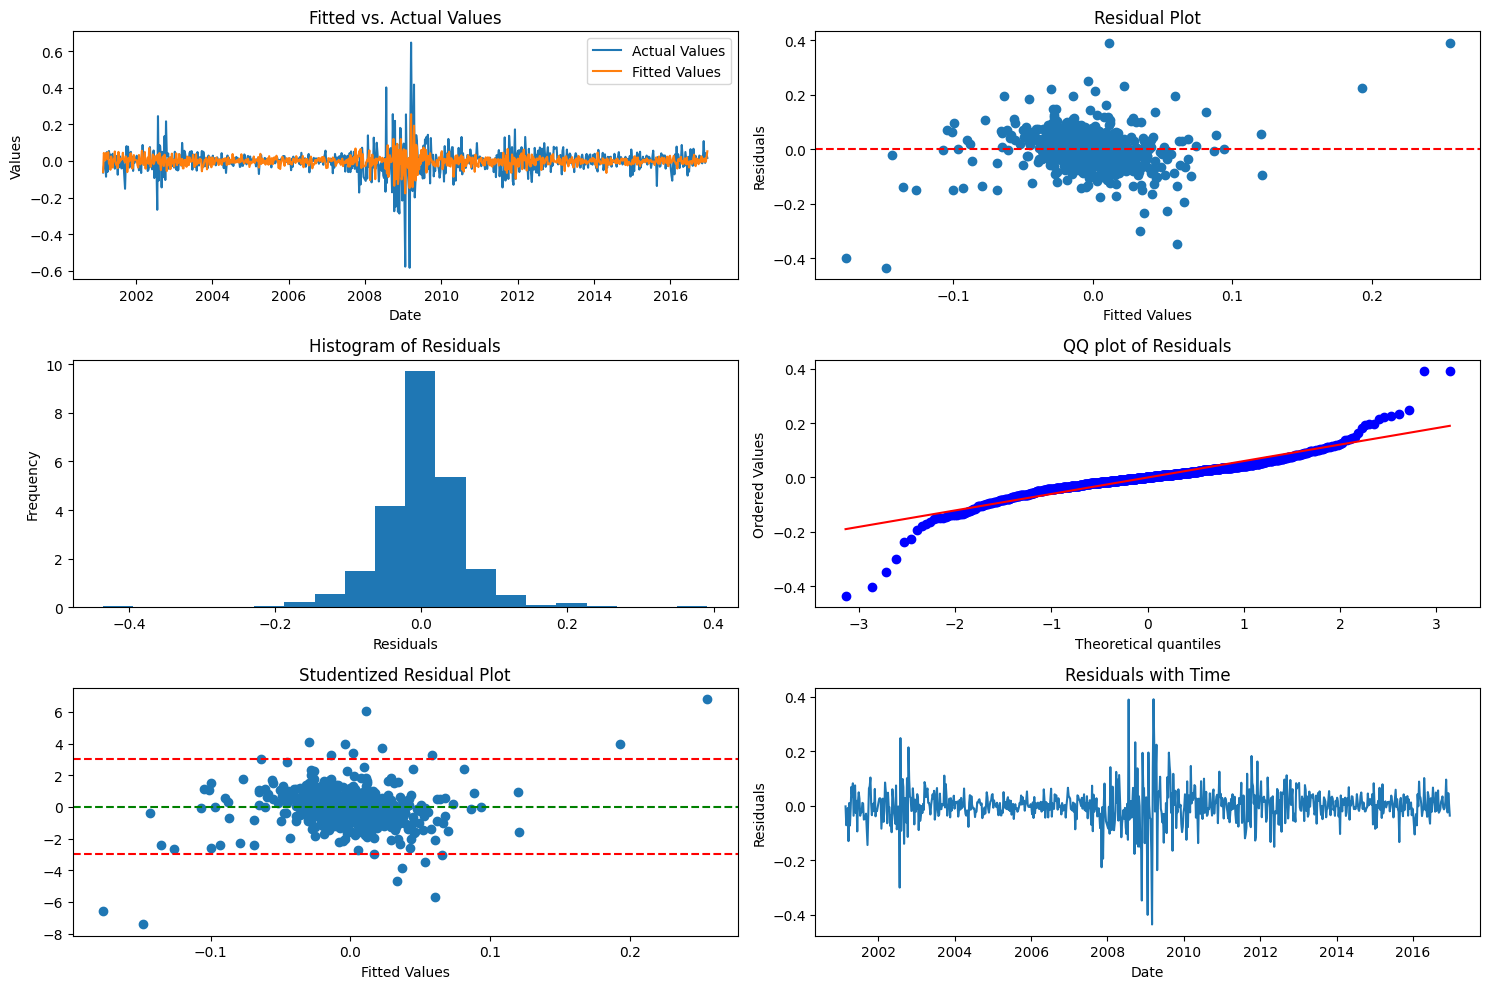

In [ ]:
diagnostic_plots(X, y_transformed, results_t,dates)

Multicolinearity:
                         feature       VIF
0                          const  1.020644
1                 Citigroup_lag1  2.453622
2            JPMorgan Chase_lag1  2.972090
3             Goldman Sachs_lag1  3.886328
4            Morgan Stanley_lag1  4.231785
5                 Citigroup_lag2  3.714343
6           Bank of America_lag2  3.725852
7            JPMorgan Chase_lag2  2.988500
8            Morgan Stanley_lag2  2.498294
9            JPMorgan Chase_lag3  3.193149
10              Wells Fargo_lag3  2.492580
11           Morgan Stanley_lag3  2.412393
12              S&P500_diff_lag3  2.365196
13           Inflation_diff_lag3  1.056881
14                Citigroup_lag4  3.937670
15          Bank of America_lag4  4.429869
16           JPMorgan Chase_lag4  3.628623
17              Wells Fargo_lag4  3.427749
18           Morgan Stanley_lag4  2.549536
19  Federal Funds Rate_diff_lag4  1.056413
Normality:
Kolmogorov-Smirnov test p-value: 1.254278885370353e-137
Residuals ar

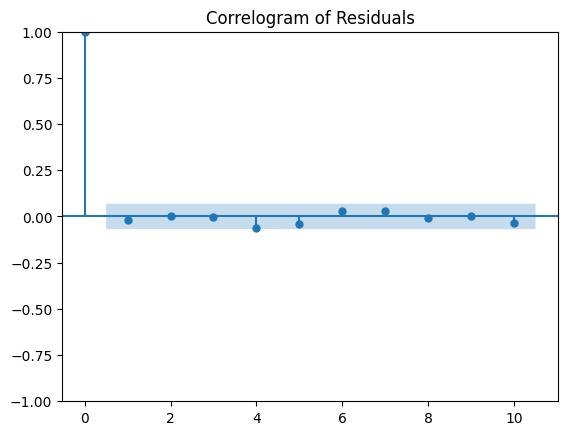

In [ ]:
check_assumptions(results_t, X)

This transformation didn't help either. But we can use the **Huber White estimator** for our Var( ${\beta}$ ) estimates.


In [ ]:
# working with the backward selected model
robust_se = results.get_robustcov_results(cov_type='HC3')
print(robust_se.summary())

                            OLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     2.094
Date:                Mon, 14 Apr 2025   Prob (F-statistic):            0.00412
Time:                        18:07:27   Log-Likelihood:                 1078.9
No. Observations:                 817   AIC:                            -2118.
Df Residuals:                     797   BIC:                            -2024.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

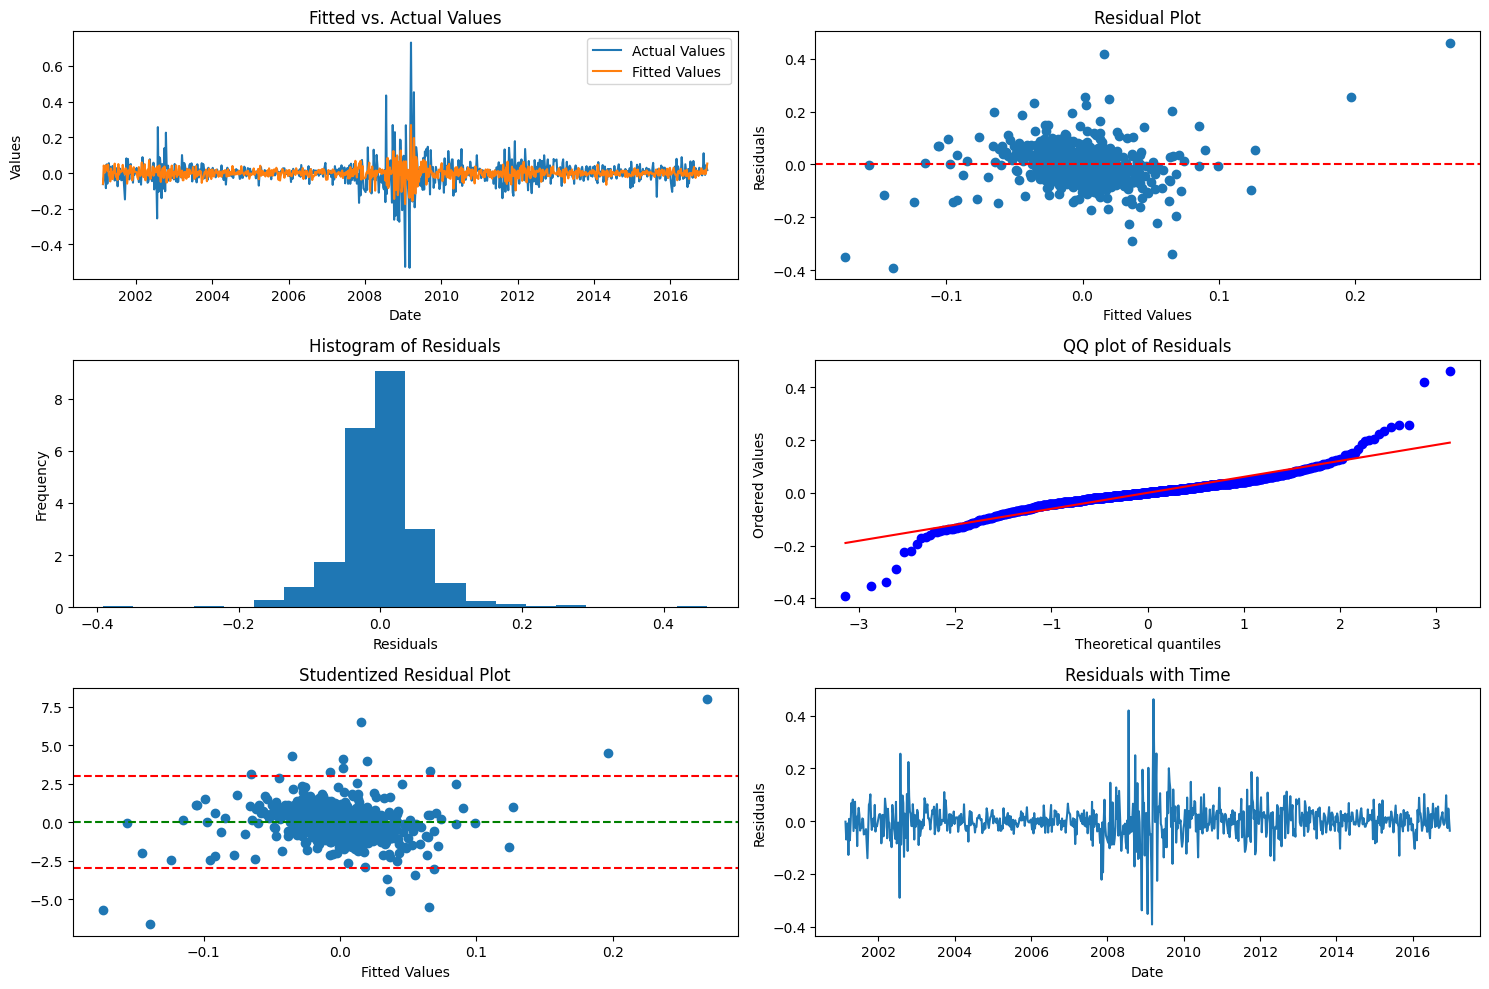

In [ ]:
diagnostic_plots(X, y, robust_se,dates)

Multicolinearity:
                         feature       VIF
0                          const  1.020644
1                 Citigroup_lag1  2.453622
2            JPMorgan Chase_lag1  2.972090
3             Goldman Sachs_lag1  3.886328
4            Morgan Stanley_lag1  4.231785
5                 Citigroup_lag2  3.714343
6           Bank of America_lag2  3.725852
7            JPMorgan Chase_lag2  2.988500
8            Morgan Stanley_lag2  2.498294
9            JPMorgan Chase_lag3  3.193149
10              Wells Fargo_lag3  2.492580
11           Morgan Stanley_lag3  2.412393
12              S&P500_diff_lag3  2.365196
13           Inflation_diff_lag3  1.056881
14                Citigroup_lag4  3.937670
15          Bank of America_lag4  4.429869
16           JPMorgan Chase_lag4  3.628623
17              Wells Fargo_lag4  3.427749
18           Morgan Stanley_lag4  2.549536
19  Federal Funds Rate_diff_lag4  1.056413
Normality:
Kolmogorov-Smirnov test p-value: 9.978997016705835e-137
Residuals ar

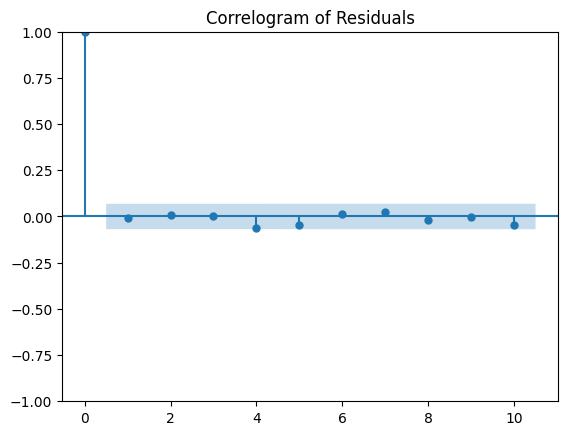

In [ ]:
check_assumptions(robust_se, X)

### Interpretation of the model
Although our normality conditions are not upheld, but we still try to give an interpretation of our coefficients because why not?:


## 📊 **Model Summary: Predicting Citigroup Returns**

We modeled the weekly **log returns of Citigroup stock** using lagged returns of major US banks and a few macroeconomic indicators. To ensure robust inference, we corrected for **heteroscedasticity** using **robust standard errors**, and although residuals were not normally distributed, the estimates remain valid.

### ✅ **Key Findings**

#### 1. **Peer Influence on Citigroup Returns**
- **Goldman Sachs (Lag 1)** has a **strong positive influence** on Citigroup’s return. This suggests that **positive movements in Goldman Sachs’s stock last week are likely followed by positive returns for Citigroup this week**. This may reflect investor sentiment toward the investment banking segment of the financial sector.
- **Morgan Stanley (Lag 1)**, in contrast, has a **negative influence**, indicating that **when Morgan Stanley performs well, Citigroup tends to perform worse**, possibly reflecting **competition or differing market exposure** between these two firms.
- **Bank of America (Lag 2)** also shows a **significant positive effect**, supporting the idea of **spillover effects** within the commercial banking sub-sector.

#### 2. **Citigroup's Own Past Returns**
- **Lag 2 of Citigroup’s own returns** is **negatively related** to its current return, indicating **mean reversion** — i.e., if the stock performed well two weeks ago, it tends to correct or decline slightly this week. This is common in financial time series and useful for short-term forecasting.

#### 3. **Macroeconomic Effects**
- **Inflation (Lag 3)** and **S&P 500 (Lag 3)** show **weak but marginal effects**. Inflation has a **positive relationship**, suggesting that **rising inflation expectations may be linked to stronger bank returns**, possibly due to anticipated interest rate hikes.
- **S&P 500** has a slightly **negative effect**, which may reflect **relative underperformance of Citigroup when the overall market rises** — this could be due to flight-to-quality during uncertainty or sectoral rotations.

#### 4. **Other Bank Lags**
- Several other lagged bank returns (e.g., JPMorgan Chase and Wells Fargo) were included but not statistically significant at the 5% level. This doesn't mean they have no effect — but their impact isn't reliably detectable in this model.

---

### 📈 **Economic Insights**
- The model shows that **Citigroup’s stock is influenced not just by its own past performance, but also by the movements of other major banks**, with stronger effects from some than others. This reflects the **interconnected nature of large financial institutions**.
- **Investor reactions to peer banks** may be delayed or reflected in Citigroup’s price with a lag, creating potential **predictive signals**.
- **Inflation and overall market movements** affect returns with a lag, suggesting **macroeconomic shocks take time to flow through** the financial sector.

---

### 🧠 **Conclusion**
The regression model captures meaningful short-term relationships among large US financial firms and selected macroeconomic indicators. While macro variables had limited significance, **peer co-movements and mean-reverting behavior** provide useful signals for modeling Citigroup’s weekly returns. These insights can support **stress testing**, **forecasting**, or understanding **systemic risk linkages** within the financial sector.



In [ ]:
# Generalized Least Squares
res = list(results.resid)
res_fit = sm.OLS(res[1:], res[:-1]).fit()
rho = res_fit.params

In [ ]:
# Custom variance model
from scipy.linalg import toeplitz
order = toeplitz(np.arange(817))
sigma = rho**order

In [ ]:
# Fitting with the custom sigma
gls_model = sm.GLS(y,X, sigma=sigma)
gls_results = gls_model.fit()
print(gls_results.summary())

                            GLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.191
Model:                            GLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     9.912
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           1.96e-26
Time:                        18:07:29   Log-Likelihood:                 1079.0
No. Observations:                 817   AIC:                            -2118.
Df Residuals:                     797   BIC:                            -2024.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Modeling Phase - II
Here we look to do cross validation for time series and try to obtain a more robust set of evaluation metrics.
Additionally we look to add the regression spline for this data.

In [ ]:
def time_series_cross_validation(X, y, model_func, cv=5):
    """
    Performs time series cross-validation and evaluates model performance using MAE,MSE and R2 score.

    Args:
        X : Independent variables.
        y : Dependent variable.
        model_func : Function to create and fit the model (e.g., sm.OLS).
        cv : Number of cross-validation folds.

    Returns:
        dict : A set of lists of MAE, RMSE and R2 scores for each fold.
    """
    tscv = TimeSeriesSplit(n_splits=cv,test_size=40)
    mae_scores, rmse_scores, adj_r2_scores, aic, bic = [], [], [], [], []
    for train_index, test_index in tscv.split(X):
        # print(train_index)
        # print(test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        model = model_func(y_train, X_train)
        results = model.fit()

        # Predict on the test set
        y_pred = results.predict(X_test)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print((len(y_test)-X_test.shape[1]-1))
        adj_R2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
        aic_ = results.aic
        bic_ = results.bic

        mae_scores.append(mae)
        rmse_scores.append(rmse)
        adj_r2_scores.append(adj_R2)
        aic.append(aic_)
        bic.append(bic_)

    return {"MAE" : mae_scores, "RMSE" : rmse_scores, "AdjR2": adj_r2_scores,"AIC" : aic, "BIC":bic}


In [ ]:
scores = pd.DataFrame(data=time_series_cross_validation(X, y, sm.OLS))
scores.apply(np.mean)

19
19
19
19
19


MAE         0.028658
RMSE        0.036956
AdjR2      -1.508539
AIC     -1727.425071
BIC     -1636.555605
dtype: float64

### Using Regression on two timelines

We fit separate models for the periods before and after the 2008 Financial Crisis to examine how the relationships between stock returns, macroeconomic factors, and competitor banks evolved in response to the crisis.

In [ ]:
# Split the DataFrame
df_before_2008 = df[df['Date'] < '2008-09-01']
df_after_2009 = df[df['Date'] >= '2009-04-01']

### Before Sept. 2008

In [ ]:
# Define dependent and independent variables
dates = df_before_2008['Date']
y = df_before_2008['Citigroup']
X = df_before_2008[['Citigroup_lag1', 'Citigroup_lag2', 'Citigroup_lag3', 'Citigroup_lag4',
        'Bank of America_lag1', 'Bank of America_lag2', 'Bank of America_lag3', 'Bank of America_lag4',
        'JPMorgan Chase_lag1', 'JPMorgan Chase_lag2', 'JPMorgan Chase_lag3', 'JPMorgan Chase_lag4',
        'Wells Fargo_lag1', 'Wells Fargo_lag2', 'Wells Fargo_lag3', 'Wells Fargo_lag4',
        'Goldman Sachs_lag1', 'Goldman Sachs_lag2', 'Goldman Sachs_lag3', 'Goldman Sachs_lag4',
        'Morgan Stanley_lag1', 'Morgan Stanley_lag2', 'Morgan Stanley_lag3', 'Morgan Stanley_lag4',
        'S&P500_diff_lag1', 'S&P500_diff_lag2', 'S&P500_diff_lag3', 'S&P500_diff_lag4',
        'GDP_diff_lag1', 'GDP_diff_lag2', 'GDP_diff_lag3', 'GDP_diff_lag4',
        'Inflation_diff_lag1', 'Inflation_diff_lag2', 'Inflation_diff_lag3', 'Inflation_diff_lag4',
        'Federal Funds Rate_diff_lag1', 'Federal Funds Rate_diff_lag2', 'Federal Funds Rate_diff_lag3', 'Federal Funds Rate_diff_lag4']]

                            OLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     3.041
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           2.05e-08
Time:                        18:07:29   Log-Likelihood:                 657.22
No. Observations:                 386   AIC:                            -1232.
Df Residuals:                     345   BIC:                            -1070.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

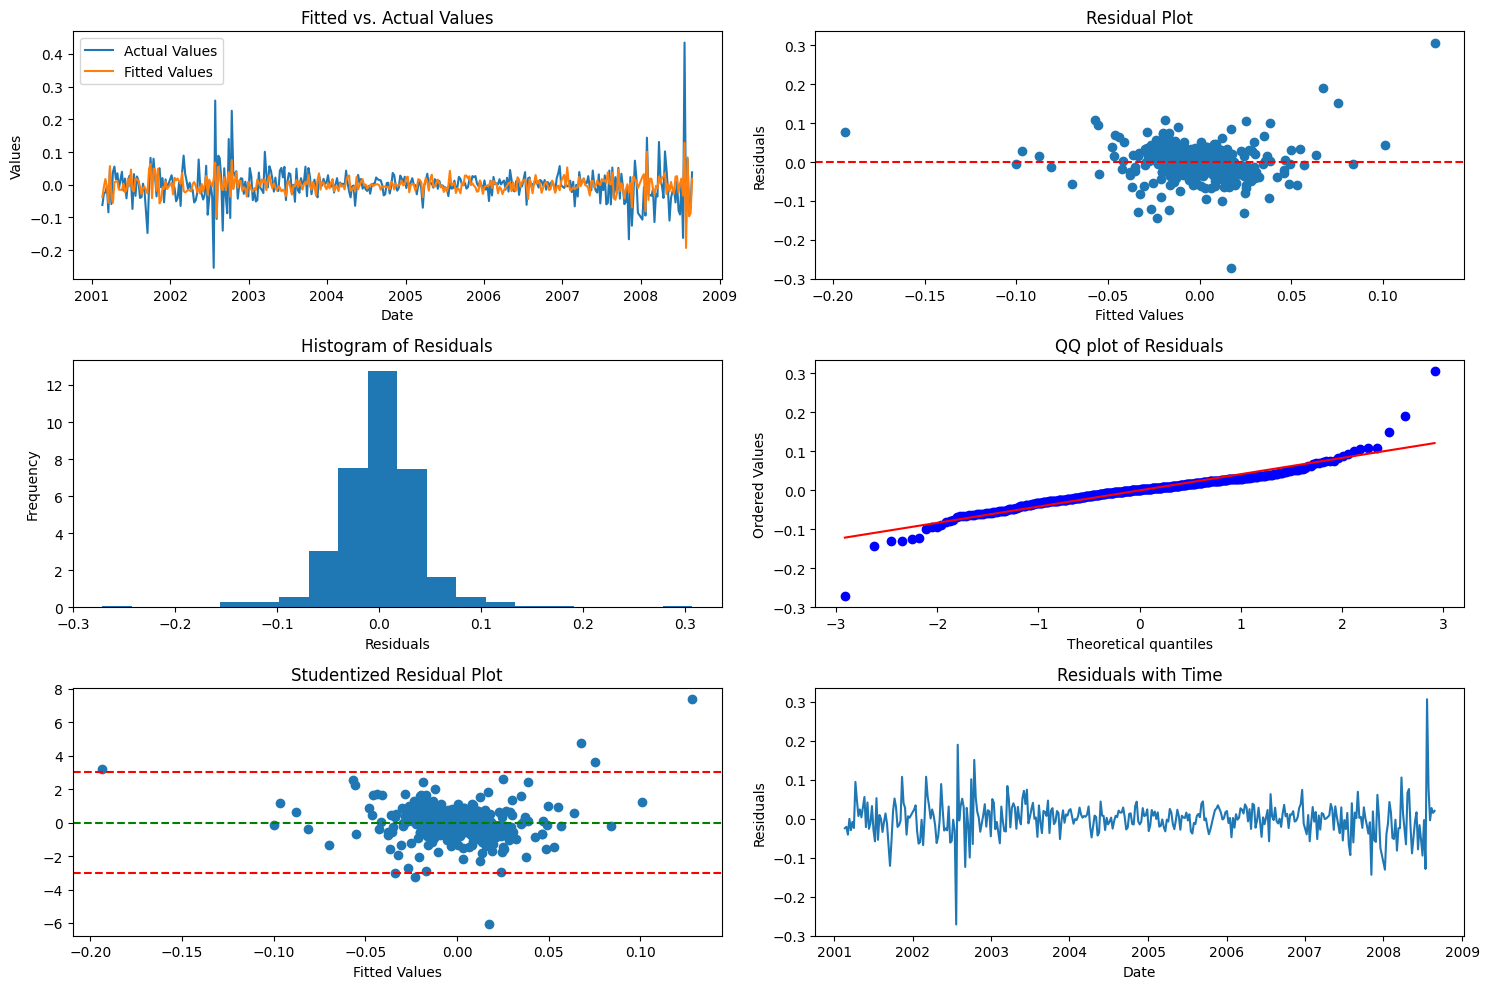

In [ ]:
# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the model summary
print(results.summary())

# Diagnostic plots
diagnostic_plots(X, y, results,dates)

Multicolinearity:
                         feature        VIF
0                          const   1.087636
1                 Citigroup_lag1   6.902277
2                 Citigroup_lag2   7.016768
3                 Citigroup_lag3   6.805756
4                 Citigroup_lag4   6.673914
5           Bank of America_lag1   5.991060
6           Bank of America_lag2   5.890078
7           Bank of America_lag3   5.875997
8           Bank of America_lag4   5.688488
9            JPMorgan Chase_lag1   4.917302
10           JPMorgan Chase_lag2   4.588534
11           JPMorgan Chase_lag3   4.452663
12           JPMorgan Chase_lag4   4.617457
13              Wells Fargo_lag1   5.565756
14              Wells Fargo_lag2   5.380142
15              Wells Fargo_lag3   5.253844
16              Wells Fargo_lag4   4.917159
17            Goldman Sachs_lag1   4.232316
18            Goldman Sachs_lag2   4.014033
19            Goldman Sachs_lag3   3.968784
20            Goldman Sachs_lag4   4.154291
21           M

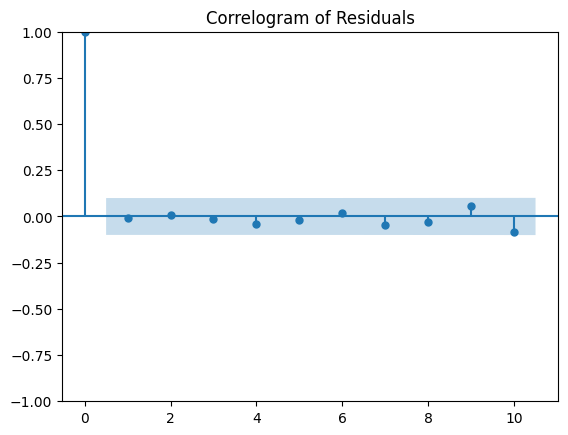

In [ ]:
check_assumptions(results,X)

After doing the backward selection, we obtain these columns
Citigroup_lag1, Wells.Fargo_lag1, S.P500_diff_lag1, GDP_diff_lag1,Inflation_diff_lag1, Federal.Funds.Rate_diff_lag1,Citigroup_lag2,    
Bank.of.America_lag2, Wells.Fargo_lag2, GDP_diff_lag2, Inflation_diff_lag2,    Federal.Funds.Rate_diff_lag2, Bank.of.America_lag3, Goldman.Sachs_lag3, Morgan.Stanley_lag3, GDP_diff_lag3, Inflation_diff_lag3, Bank.of.America_lag4, JPMorgan.Chase_lag4, Wells.Fargo_lag4, Morgan.Stanley_lag4            GDP_diff_lag4, Federal.Funds.Rate_diff_lag4

In [ ]:
X = df_before_2008[["Citigroup_lag1", "Wells Fargo_lag1", "S&P500_diff_lag1", "GDP_diff_lag1" ,"Inflation_diff_lag1", "Federal Funds Rate_diff_lag1","Citigroup_lag2",
                      "Bank of America_lag2", "Wells Fargo_lag2", "GDP_diff_lag2", "Inflation_diff_lag2",    "Federal Funds Rate_diff_lag2", "Bank of America_lag3", "Goldman Sachs_lag3",
                    "Morgan Stanley_lag3", "GDP_diff_lag3", "Inflation_diff_lag3", "Bank of America_lag4", "JPMorgan Chase_lag4", "Wells Fargo_lag4", "Morgan Stanley_lag4",
                      "GDP_diff_lag4", "Federal Funds Rate_diff_lag4"]]

                            OLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     5.205
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           1.11e-12
Time:                        18:07:31   Log-Likelihood:                 654.08
No. Observations:                 386   AIC:                            -1260.
Df Residuals:                     362   BIC:                            -1165.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

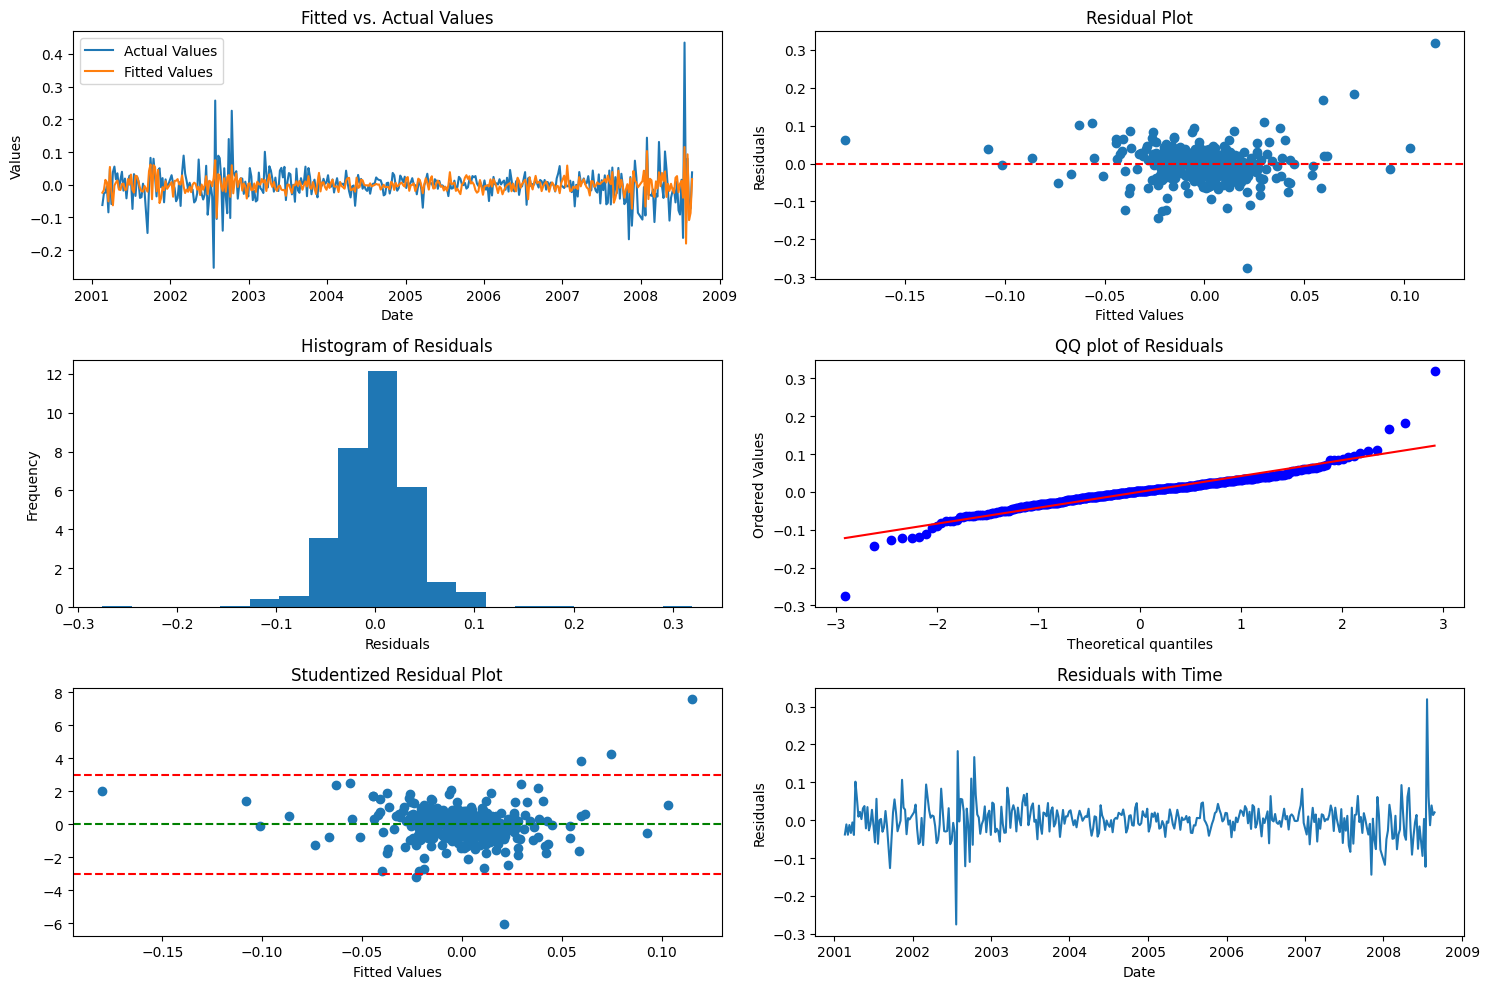

In [ ]:
# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the model summary
print(results.summary())

# Diagnostic plots
diagnostic_plots(X, y, results,dates)

Multicolinearity:
                         feature       VIF
0                          const  1.038273
1                 Citigroup_lag1  3.101640
2               Wells Fargo_lag1  2.674406
3               S&P500_diff_lag1  2.660746
4                  GDP_diff_lag1  1.579920
5            Inflation_diff_lag1  2.114961
6   Federal Funds Rate_diff_lag1  2.664041
7                 Citigroup_lag2  4.025522
8           Bank of America_lag2  5.180554
9               Wells Fargo_lag2  4.440662
10                 GDP_diff_lag2  1.785917
11           Inflation_diff_lag2  2.685078
12  Federal Funds Rate_diff_lag2  2.895870
13          Bank of America_lag3  1.758355
14            Goldman Sachs_lag3  3.291715
15           Morgan Stanley_lag3  3.465583
16                 GDP_diff_lag3  1.683172
17           Inflation_diff_lag3  2.129028
18          Bank of America_lag4  4.210676
19           JPMorgan Chase_lag4  3.611664
20              Wells Fargo_lag4  4.235279
21           Morgan Stanley_lag4  2.

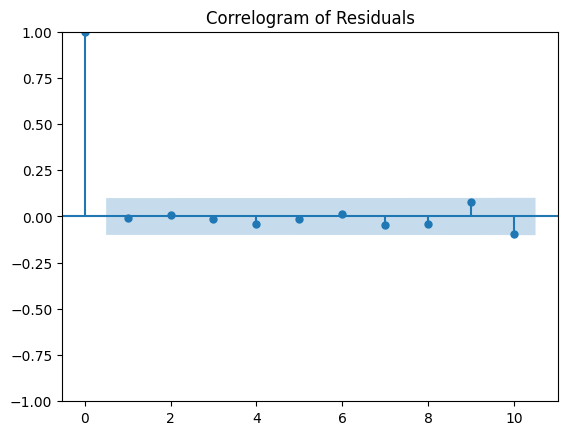

In [ ]:
check_assumptions(results,X)

In [ ]:
# Cross Validation Metrics
metrics = pd.DataFrame(time_series_cross_validation(X,y,sm.OLS))
metrics.apply(np.mean)

15
15
15
15
15


MAE        0.032570
RMSE       0.043939
AdjR2     -3.964899
AIC     -914.259056
BIC     -828.820007
dtype: float64

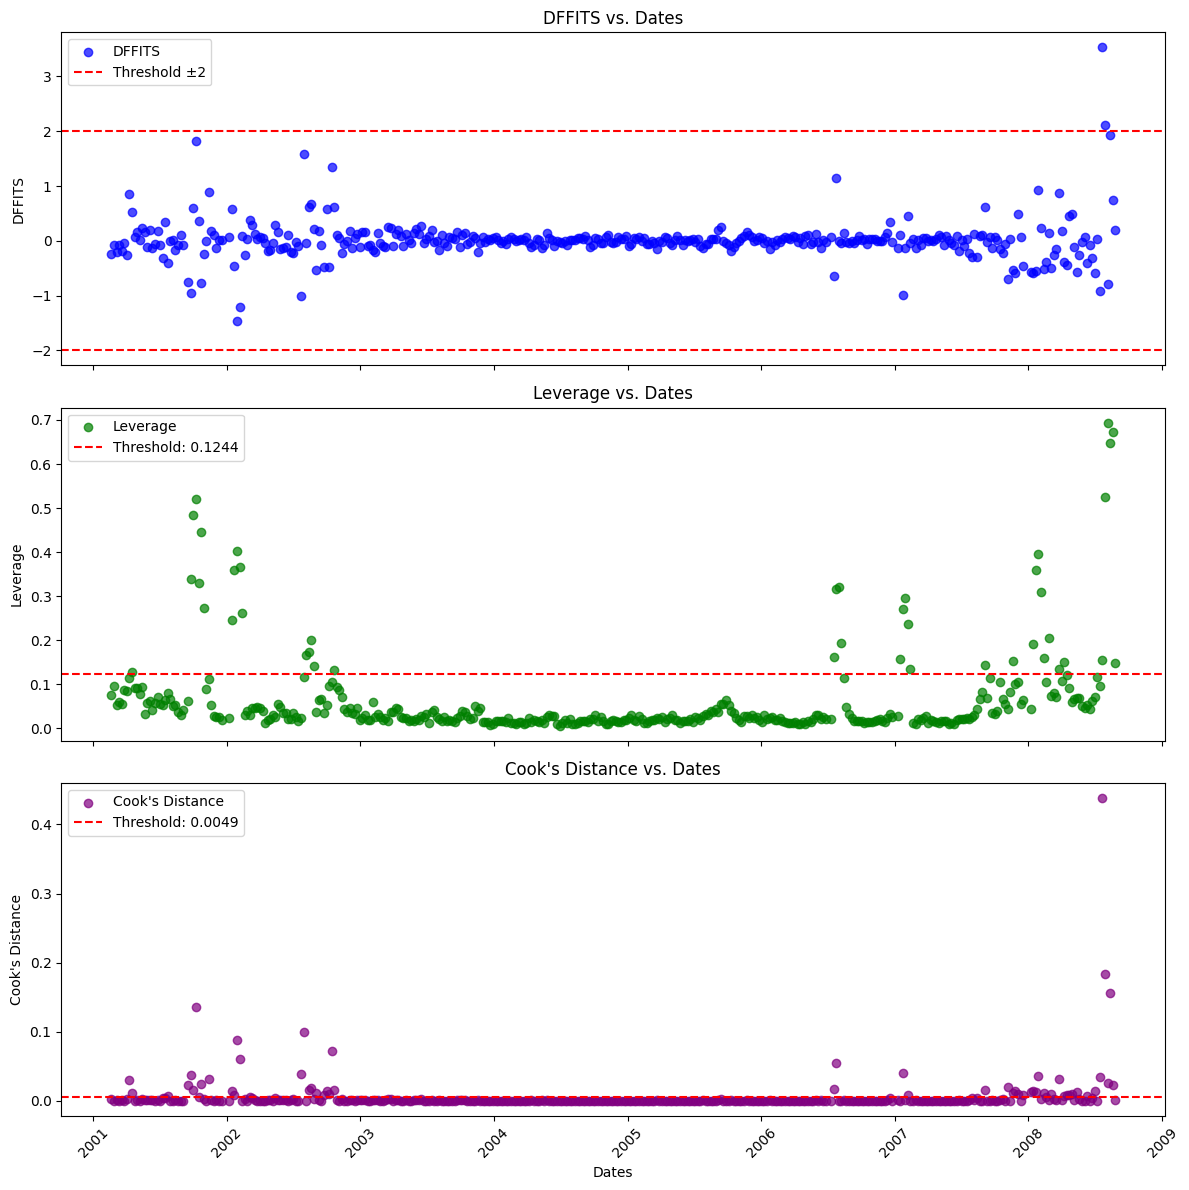

In [ ]:
inf_dates = plot_influence_diagnostics(results, dates)

As heteroscedasticity is present, we use a robust estimate of the standard errors.

In [ ]:
# working with the backward selected model
robust_se = results.get_robustcov_results(cov_type='HC3')
print(robust_se.summary())

                            OLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     1.974
Date:                Mon, 14 Apr 2025   Prob (F-statistic):            0.00528
Time:                        18:07:34   Log-Likelihood:                 654.08
No. Observations:                 386   AIC:                            -1260.
Df Residuals:                     362   BIC:                            -1165.
Df Model:                          23                                         
Covariance Type:                  HC3                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### After Apr. 2009

Backward selection gives the best model.
The variables are:

['JPMorgan.Chase_lag1', 'Inflation_diff_lag2', 'Wells.Fargo_lag3',
 'Morgan.Stanley_lag3', 'JPMorgan.Chase_lag3', 'Bank.of.America_lag4',
 'Morgan.Stanley_lag4', 'Goldman.Sachs_lag2', 'S.P500_diff_lag1',
 'Wells.Fargo_lag1', 'Wells.Fargo_lag4', 'Morgan.Stanley_lag1',
 'Goldman.Sachs_lag1', 'Bank.of.America_lag3', 'Goldman.Sachs_lag4',
 'S.P500_diff_lag2', 'Morgan.Stanley_lag2', 'S.P500_diff_lag4']


In [ ]:
X = df_after_2009[['JPMorgan Chase_lag1', 'Inflation_diff_lag2', 'Wells Fargo_lag3','Morgan Stanley_lag3', 'JPMorgan Chase_lag3', 'Bank of America_lag4',
                    'Morgan Stanley_lag4', 'Goldman Sachs_lag2', 'S&P500_diff_lag1','Wells Fargo_lag1', 'Wells Fargo_lag4', 'Morgan Stanley_lag1',
                    'Goldman Sachs_lag1', 'Bank of America_lag3', 'Goldman Sachs_lag4','S&P500_diff_lag2', 'Morgan Stanley_lag2', 'S&P500_diff_lag4']]
y = df_after_2009['Citigroup']
dates = df_after_2009['Date']

                            OLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3.053
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           3.25e-05
Time:                        18:07:34   Log-Likelihood:                 614.33
No. Observations:                 400   AIC:                            -1191.
Df Residuals:                     381   BIC:                            -1115.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0019 

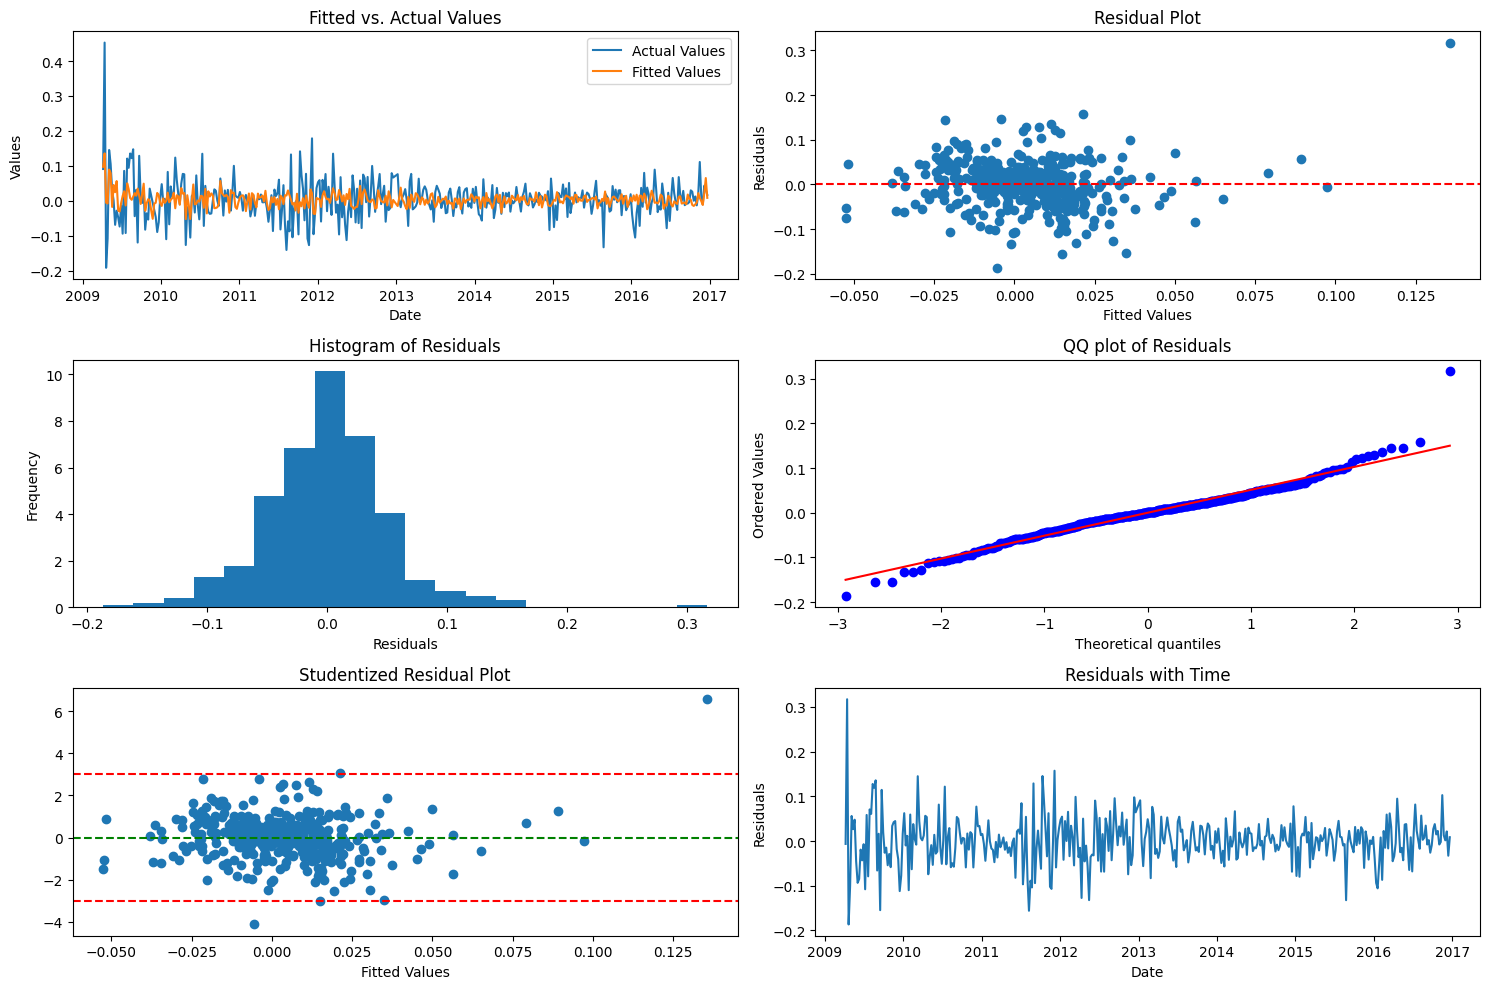

In [ ]:
# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the model summary
print(results.summary())

# Diagnostic plots
diagnostic_plots(X, y, results,dates)

In [ ]:
# Cross Validation Metrics
metrics = pd.DataFrame(time_series_cross_validation(X,y,sm.OLS))
metrics.apply(np.mean)

20
20
20
20
20


MAE        0.029345
RMSE       0.038025
AdjR2     -1.497872
AIC     -773.968864
BIC     -705.309814
dtype: float64

Multicolinearity:
                 feature       VIF
0                  const  1.050450
1    JPMorgan Chase_lag1  4.248233
2    Inflation_diff_lag2  1.099905
3       Wells Fargo_lag3  3.555990
4    Morgan Stanley_lag3  3.204940
5    JPMorgan Chase_lag3  4.205767
6   Bank of America_lag4  3.368963
7    Morgan Stanley_lag4  4.113076
8     Goldman Sachs_lag2  3.601464
9       S&P500_diff_lag1  3.004595
10      Wells Fargo_lag1  2.766574
11      Wells Fargo_lag4  2.945332
12   Morgan Stanley_lag1  4.260334
13    Goldman Sachs_lag1  3.934084
14  Bank of America_lag3  3.416405
15    Goldman Sachs_lag4  3.503794
16      S&P500_diff_lag2  3.052536
17   Morgan Stanley_lag2  3.645719
18      S&P500_diff_lag4  1.468628
Normality:
Kolmogorov-Smirnov test p-value: 3.5202394549854548e-71
Residuals are not normally distributed (reject null hypothesis)
Heteroscedasticity:
White Test:
The p- value is 2.5126646061720273e-10
Heteroscedasticity is present.

Breusch-Pagan Test:
The p- value is 9.2378587795

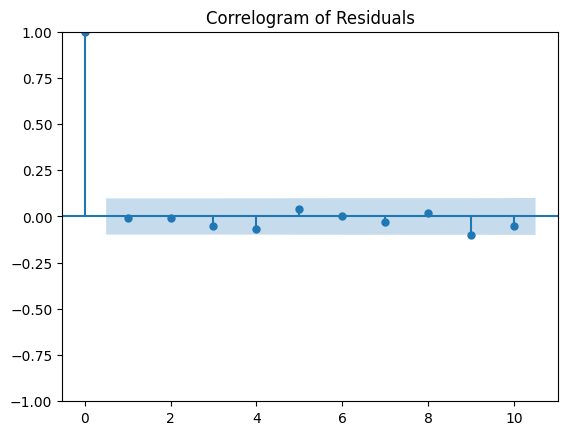

In [ ]:
check_assumptions(results,X)

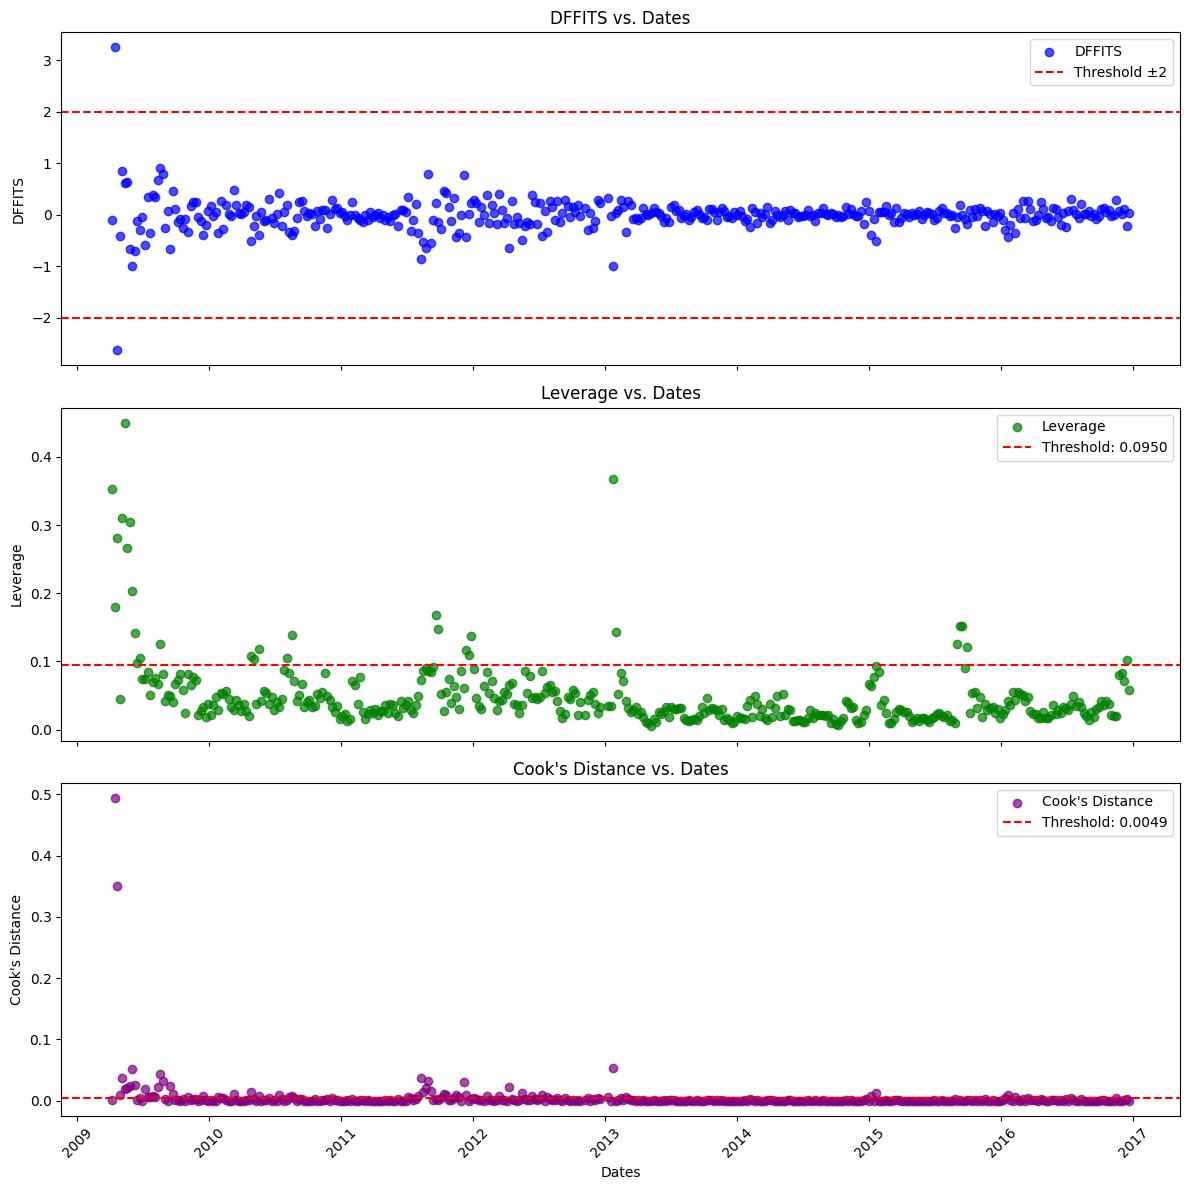

In [ ]:
inf_dates_a9 = plot_influence_diagnostics(results, dates)

In [ ]:
# robust standard error
robust_se = results.get_robustcov_results(cov_type='HC3')
print(robust_se.summary())

                            OLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     1.242
Date:                Mon, 14 Apr 2025   Prob (F-statistic):              0.224
Time:                        18:07:37   Log-Likelihood:                 614.33
No. Observations:                 400   AIC:                            -1191.
Df Residuals:                     381   BIC:                            -1115.
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0019 

# 📈 Comparative Regression Analysis of Citigroup Returns: Pre vs Post 2008 Crisis

### **Overview**
This analysis compares two regression models predicting **Citigroup's return ratio**:
- **Pre-crisis model**: Based on data **before September 2008**
- **Post-crisis model**: Based on data **after April 2009**

Each model includes:
- Lagged return ratios of Citigroup and five major U.S. banks
- Lagged macroeconomic indicators (Inflation, GDP, Federal Funds Rate, S&P 500)

---

## ⚙️ Model Summary

| Metric                         | **Pre-2008 Model**     | **Post-2009 Model**     |
|-------------------------------|------------------------|--------------------------|
| Observations                  | 386                    | 400                      |
| R-squared                     | 0.249                  | 0.126                    |
| Adjusted R-squared            | 0.201                  | 0.085                    |
| AIC                           | -1260                  | -1191                    |
| BIC                           | -1165                  | -1115                    |
| F-statistic (p-value)         | 1.974 (**p=0.005**)    | 1.242 (**p=0.224**)      |

### 🔍 Interpretation:
- **Pre-crisis model** had stronger predictive power.
- **Post-crisis model** explains significantly less variance in Citigroup’s returns.
- Indicates structural and behavioral changes in financial markets after the 2008 crisis.

---

## 📊 Key Drivers and Economic Interpretation

### ✅ **Significant Predictors – Pre 2008**

| Variable                          | Sign | Interpretation |
|-----------------------------------|------|----------------|
| **Inflation_diff_lag1**           | +    | Inflation boosted returns — possibly via higher interest margins. |
| **Federal Funds Rate_diff_lag1**  | −    | Higher rates dampened returns — costlier borrowing. |
| **Federal Funds Rate_diff_lag2**  | −    | Lagged tightening effects persisted. |
| **Goldman Sachs_lag3**            | −    | Potential early signs of investment bank stress affecting Citi. |
| **JPMorgan Chase_lag4**           | −    | Competitive or systemic effects from peer returns. |
| **BoA_lag4, Wells Fargo_lag2**    | −    | Bank sector-wide interconnected pressures. |
| **Wells Fargo_lag4**              | +    | Possibly a delayed market confidence spillover. |
| **Morgan Stanley_lag4**           | +    | Reflects co-movement in stock returns. |

> 💡 **Insight**: Before the crisis, Citigroup’s returns were responsive to traditional macroeconomic variables and tightly linked to peer banks — reflecting a **predictable, interconnected system**.

---

### ❌ **Significant Predictors – Post 2009**

| Variable                          | Sign | Interpretation |
|-----------------------------------|------|----------------|
| **JPMorgan Chase_lag3**           | +    | May reflect JPMorgan's leadership in a recovering market. |
| **Goldman Sachs_lag4**            | ~+   | Borderline significant — investment bank influence resurging. |

> 💡 **Insight**: Post-crisis, Citigroup's return dynamics became **more idiosyncratic** and **less tied to macro signals**. Peer bank influence weakened or became delayed, likely due to regulatory changes and market disruptions.

---

## 📉 Economic Context

### 💥 Pre-2008
- Stable macro-financial linkages.
- Central bank policy (interest rates) had clear effects on bank performance.
- Investment banks had substantial market influence.

### 🌪️ Post-2009
- Financial system underwent **major structural reforms** (e.g., Dodd-Frank, Basel III).
- Interest rates remained **artificially low** (ZIRP/QE), reducing explanatory power.
- **Risk appetite and return dynamics** shifted toward uncertainty and noise.
- Peer effects weakened as firms became **more idiosyncratic** in strategies and performance.

---

## 🧠 Conclusion

- The **pre-crisis model** shows stronger and more intuitive relationships between macroeconomic indicators, peer bank performance, and Citigroup’s returns.
- The **post-crisis model** reflects a new regime where traditional predictors lost explanatory power.
- This mirrors real-world disruptions and regulatory shifts in the financial sector following the **2008 global financial crisis**.

---

## Weighted Least Squares

In [ ]:
def dual_chart(dates, y, weights):
  """

  """

  # Create the dual axis plot
  fig, ax1 = plt.subplots(figsize=(12, 6))

  # Plot weights on the first axis
  ax1.plot(dates, weights, color='tab:blue', label='Weights')
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Weights', color='tab:blue')
  ax1.tick_params(axis='y', labelcolor='tab:blue')

  # Create a second axis sharing the same x-axis
  ax2 = ax1.twinx()

  # Plot Citigroup returns on the second axis
  ax2.plot(dates, y, color='tab:red', label='Citigroup Returns')
  ax2.set_ylabel('Citigroup Returns', color='tab:red')
  ax2.tick_params(axis='y', labelcolor='tab:red')

  # Add title and legend
  plt.title('Citigroup Returns and Weights Over Time')
  fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

  # Show the plot
  plt.show()


In [ ]:
def weighted_least_squares(X, y, dates,bandwidth=None,crucial_date=None):
  """
  Gives a weighted least square model using a gaussian weights

  Args:
    X : the independent variables
    y : the dependent variable
    dates : the dates of the data
    bandwidth : the bandwidth of the gaussian weights
    crucial_date : the date on which the weights are maximum
    bandwidth : the bandwidth of the gaussian weights

  Returns:
    wls_results : the weighted least squares model
  """
  crucial_date = pd.to_datetime('2008-09-01') if crucial_date == None else crucial_date
  if bandwidth == None:
    bandwidth = max((dates.max() - crucial_date).days, (crucial_date - dates.min()).days) / 3
  # Calculate the time difference in days.
  time_diff = (dates - crucial_date).dt.days

  weights = np.exp(-0.5 * (time_diff / bandwidth)**2)

  weights = np.abs(weights)
  weights = weights / weights.min()
  # weights = [weight + 1 for weight in weights]

  # Fit WLS model
  wls_model = sm.WLS(y, X, weights=weights)
  wls_results = wls_model.fit()

  return wls_results, weights

In [ ]:
X = df[['Citigroup_lag1', 'JPMorgan Chase_lag1', 'Goldman Sachs_lag1', 'Morgan Stanley_lag1',
        'Citigroup_lag2', 'Bank of America_lag2', 'JPMorgan Chase_lag2','Morgan Stanley_lag2',
        'JPMorgan Chase_lag3', 'Wells Fargo_lag3', 'Morgan Stanley_lag3', 'S&P500_diff_lag3',
        'Inflation_diff_lag3', 'Citigroup_lag4', 'Bank of America_lag4', 'JPMorgan Chase_lag4',
        'Wells Fargo_lag4', 'Morgan Stanley_lag4', 'Federal Funds Rate_diff_lag4']]

y = df['Citigroup']
dates = df['Date']

X = sm.add_constant(X)

# Calculating bandwidth
results, weights = weighted_least_squares(X, y, dates)
print(results.summary())
# print(weights)

                            WLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.319
Model:                            WLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     19.64
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           2.53e-54
Time:                        18:13:14   Log-Likelihood:                 691.63
No. Observations:                 817   AIC:                            -1343.
Df Residuals:                     797   BIC:                            -1249.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

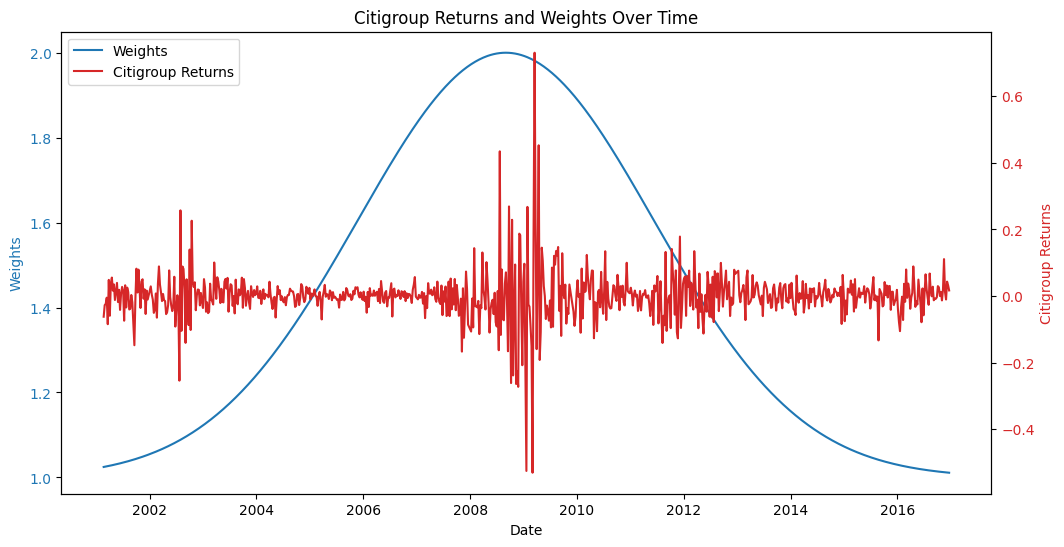

In [ ]:
dual_chart(dates, y, weights)

In [ ]:
def weighted_time_series_cross_validation(X, y, dates, cv=5):
    """
    Performs time series cross-validation and evaluates model performance using MAE,MSE and R2 score.

    Args:
        X : Independent variables.
        y : Dependent variable.
        dates : the dates of the data
        cv : Number of cross-validation folds.

    Returns:
        dict : A set of lists of MAE, RMSE and R2 scores for each fold.
    """
    tscv = TimeSeriesSplit(n_splits=cv,test_size=40)
    mae_scores, rmse_scores, adj_r2_scores, aic, bic = [], [], [], [], []
    for train_index, test_index in tscv.split(X):
        # print(train_index)
        # print(test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        dates_train, dates_test = dates.iloc[train_index], dates.iloc[test_index]

        # Fit the model
        X_train = sm.add_constant(X_train)
        results, _ = weighted_least_squares(X_train,y_train,dates_train)
        # results = model.fit()

        # Predict on the test set
        y_pred = results.predict(X_test)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        # print((len(y_test)-X_test.shape[1]-1))
        adj_R2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
        aic_ = results.aic
        bic_ = results.bic

        mae_scores.append(mae)
        rmse_scores.append(rmse)
        adj_r2_scores.append(adj_R2)
        aic.append(aic_)
        bic.append(bic_)

    return {"MAE" : mae_scores, "RMSE" : rmse_scores, "AdjR2": adj_r2_scores,"AIC" : aic, "BIC":bic}


In [ ]:
metrics = pd.DataFrame(weighted_time_series_cross_validation(X, y, dates))
metrics.apply(np.mean)

MAE         0.033307
RMSE        0.041876
AdjR2      -2.274333
AIC     -1119.106918
BIC     -1028.237451
dtype: float64

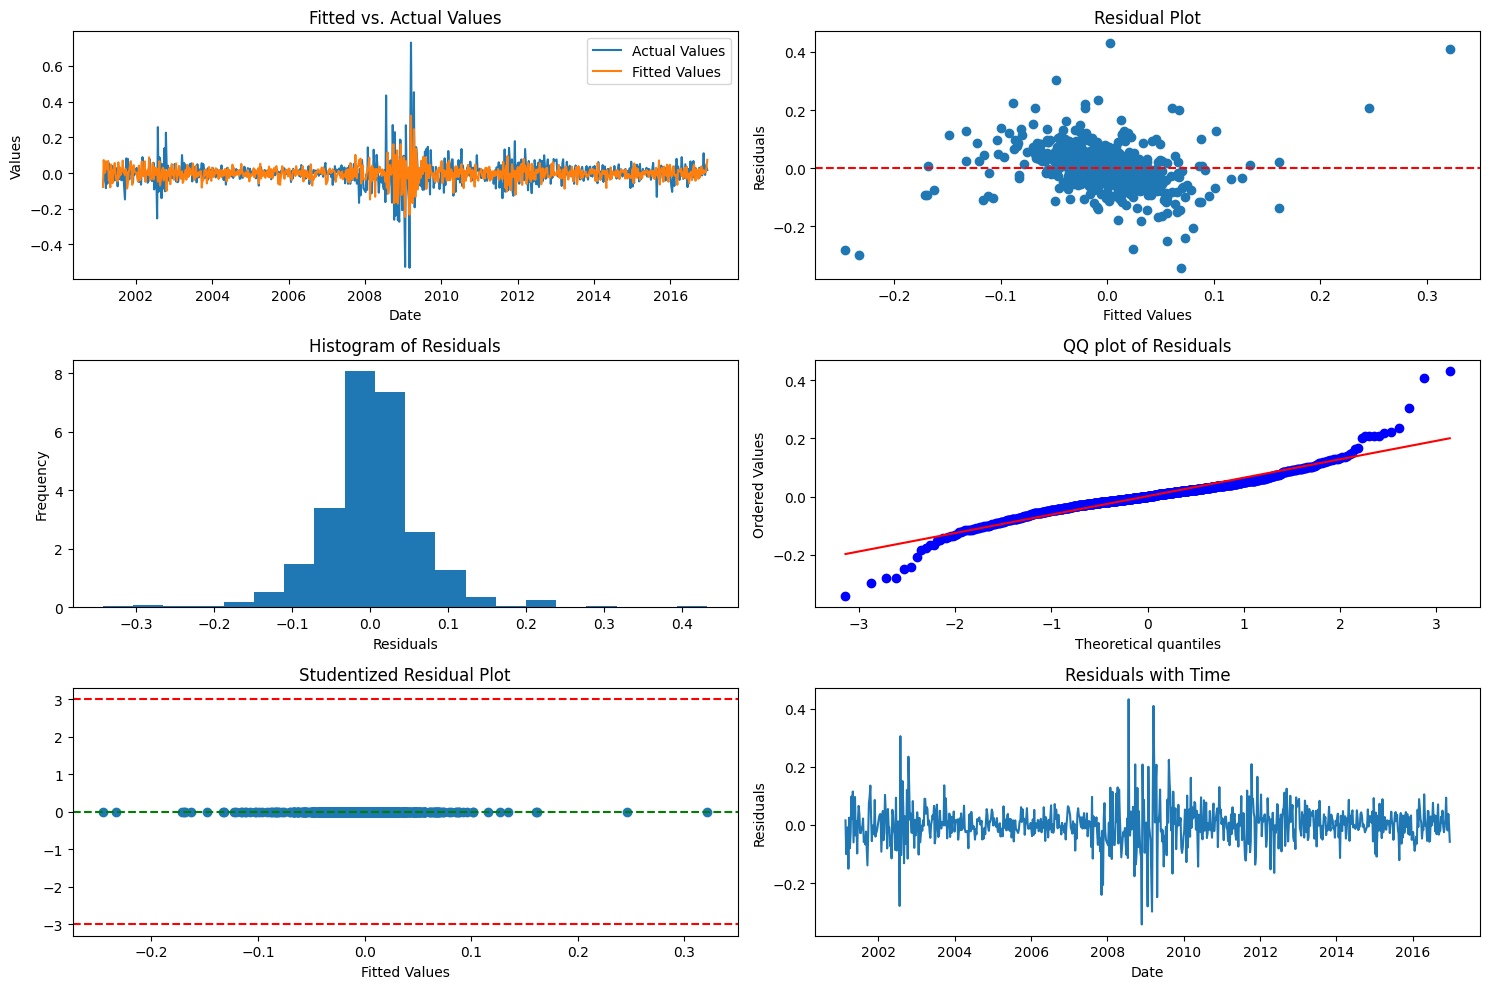

In [ ]:
diagnostic_plots(X, y, results,dates,robust=True)

## Weighted Least Squares with Change Point Analysis

In [ ]:
# importing the change point times
change_points = pd.read_csv('/content/drive/MyDrive/Regression Course Project/data/chow_test_results.csv')
change_points['Breakpoint Date'] = pd.to_datetime(change_points['Breakpoint Date'])

In [ ]:
# Extracting the dates crucial for CitiGroup
citi_dates = change_points[change_points['Citigroup'] < 0.05]['Breakpoint Date']
# citi_dates = change_points['Breakpoint Date']

In [ ]:
def calculate_variance(dates, crucial_dates, y):
  last_entry, weights, last_date = 0, [1], dates.min()
  for idx, crucial_date in enumerate(crucial_dates[1:]):
    for i, date in enumerate(dates[1:]):
      if date > last_date and date <= crucial_date:
        weights.append(np.var(y[last_entry:i+1]))

      if date > crucial_date:
        last_entry = i
        last_date = crucial_date
        break
  return weights

In [ ]:
def get_weights(dates, crucial_dates, y=None, variance=False):
  """
  Gives a weighted least square model using a mixture gaussian weights

  Args:
    dates : the dates of the data
    crucial_date : the list of dates on which the weights are maximum

  Returns: weights given to each observations
  """
  max_date, min_date = dates.max(), dates.min()
  all_crucial_dates = [min_date,*crucial_dates,max_date]
  if variance and not y.empty:
    weights = calculate_variance(dates, all_crucial_dates, y)
    return weights
  else:
    bandwidths = []
    for i in range(1,len(all_crucial_dates)):
        bandwidths.append(min((all_crucial_dates[i] - all_crucial_dates[i-1]).days, (all_crucial_dates[i-1] - all_crucial_dates[i]).days) / 3)
  weights = []
  for date in dates:
    weight = 1
    for i, crucial_date in enumerate(crucial_dates):
      weight += np.exp(-0.5 * ((date - crucial_date).days / bandwidths[i])**2)
    weights.append(weight)

  return weights


In [ ]:
weights = get_weights(dates,citi_dates)
# weights = weights/min(weights)

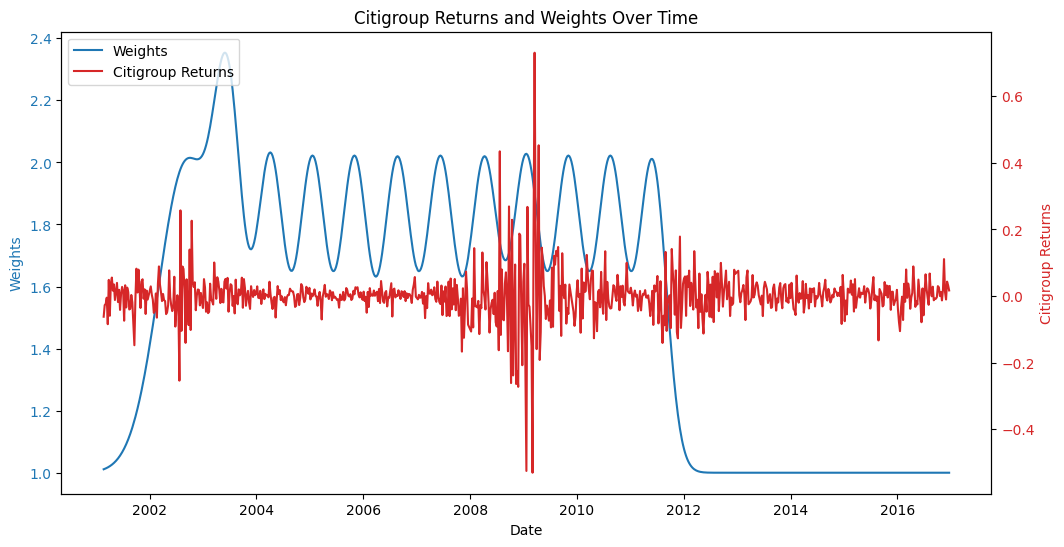

In [ ]:
dual_chart(dates, y, weights)

In [ ]:
results = sm.WLS(y, X, weights=weights).fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.219
Model:                            WLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     11.77
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           5.14e-32
Time:                        18:07:41   Log-Likelihood:                 1021.9
No. Observations:                 817   AIC:                            -2004.
Df Residuals:                     797   BIC:                            -1910.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

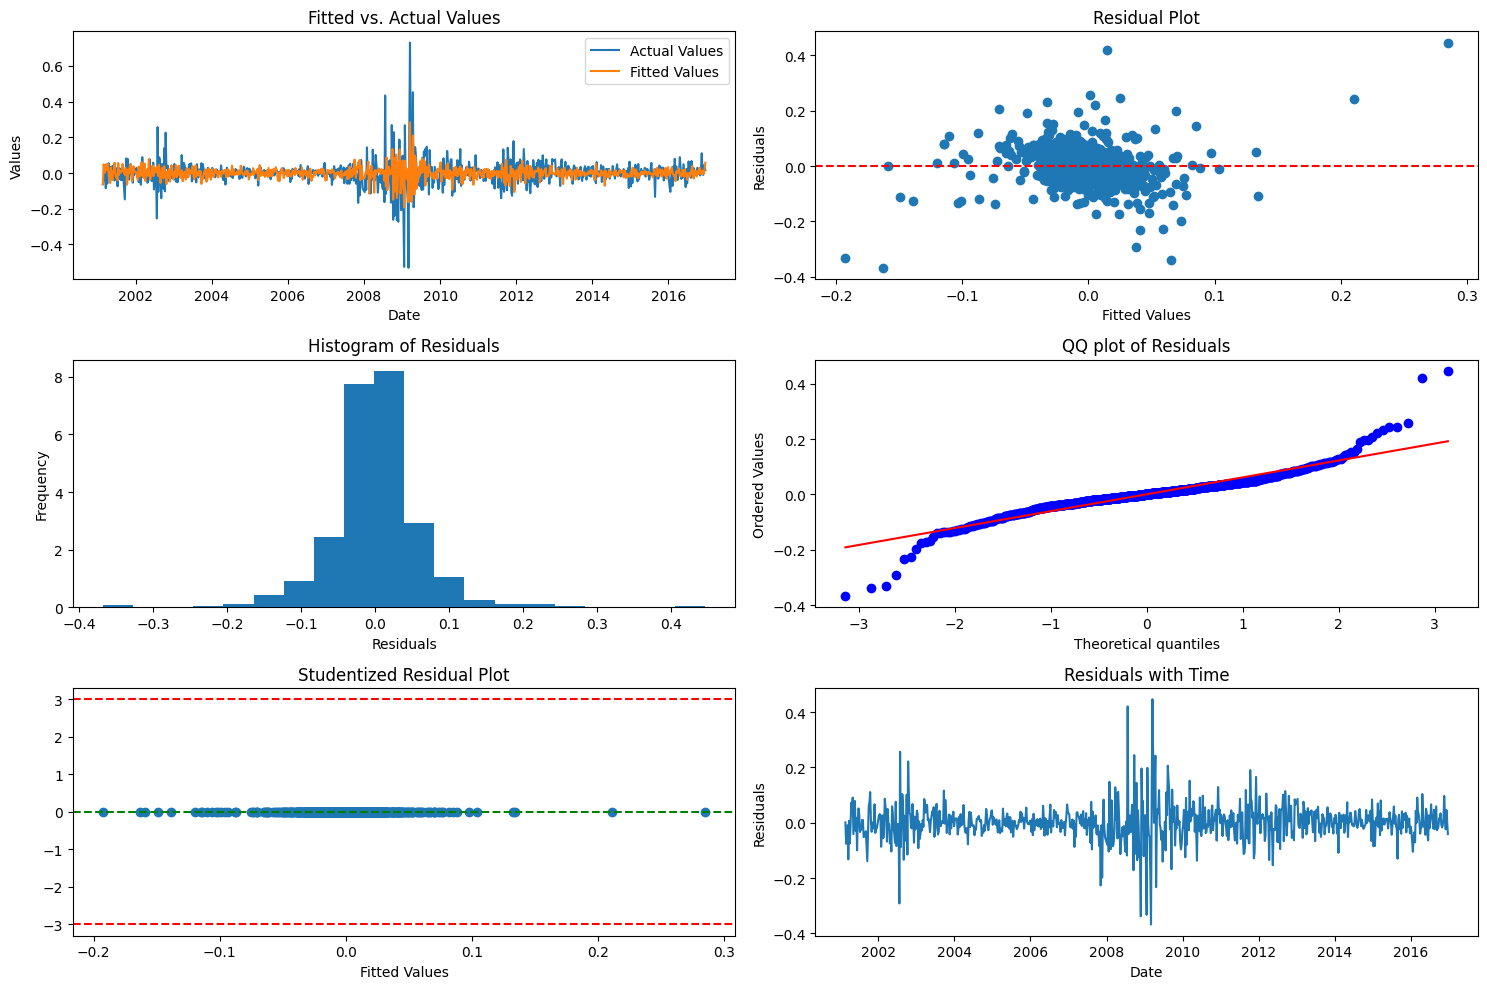

In [ ]:
diagnostic_plots(X, y, results, dates, robust=True)

In [ ]:
def plot_moving_variance(dates, y, window_size):
    """Plots the moving variance of y along with the overall variance.

    Args:
        dates: A pandas Series of dates.
        y: A pandas Series of the dependent variable.
        window_size: The size of the moving window.
    Returns:
        moving_variance: A pandas Series of the moving variance.
    """
    moving_variance = y.rolling(window=window_size).var()
    overall_variance = y.var()

    plt.figure(figsize=(12, 6))
    plt.plot(dates, moving_variance, label='Moving Variance')
    plt.axhline(overall_variance, color='red', linestyle='--', label='Overall Variance')
    plt.xlabel('Date')
    plt.ylabel('Variance')
    plt.title(f'Moving Variance of y (Window Size = {window_size})')
    plt.legend()
    plt.grid(True)
    plt.show()
    return moving_variance

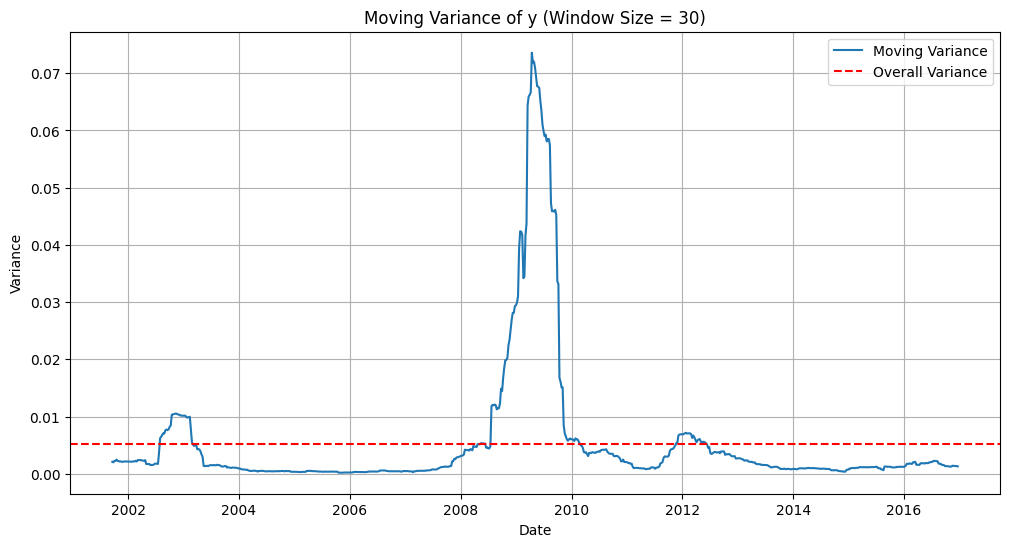

In [ ]:
moving_variance = plot_moving_variance(dates, y, window_size=30)

In [ ]:
moving_variance[moving_variance.isna()] = y.var()

In [ ]:
results = sm.WLS(y, X, weights=moving_variance).fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.567
Model:                            WLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     54.85
Date:                Mon, 14 Apr 2025   Prob (F-statistic):          1.80e-130
Time:                        18:43:12   Log-Likelihood:                 227.37
No. Observations:                 817   AIC:                            -414.7
Df Residuals:                     797   BIC:                            -320.6
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

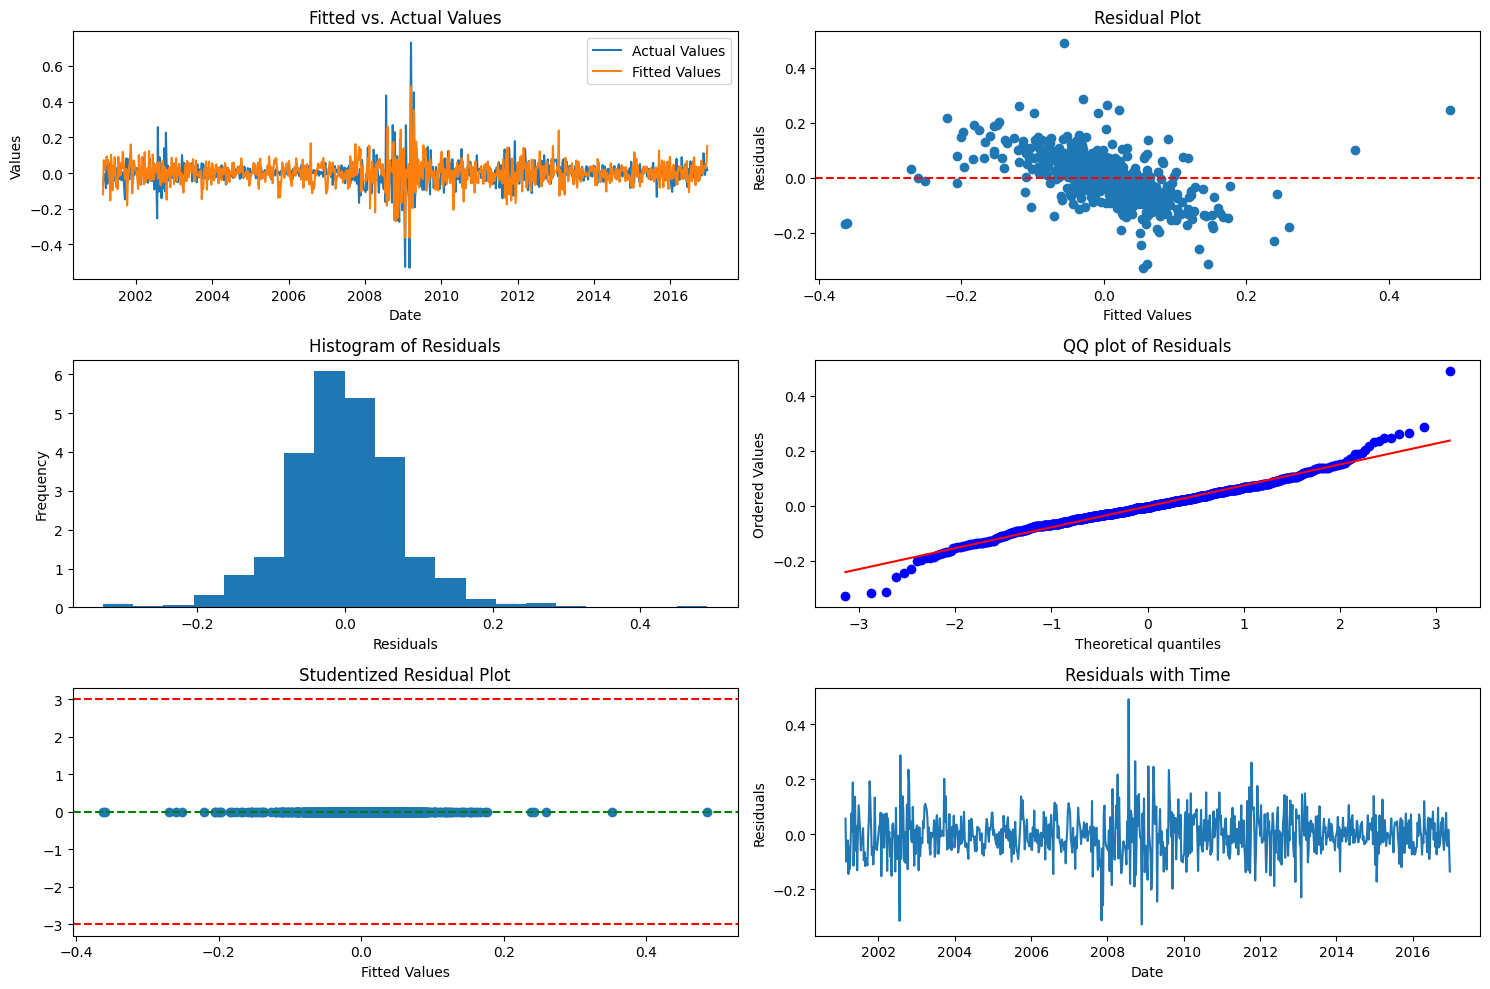

In [ ]:
diagnostic_plots(X, y, results, dates, robust=True)

Multicolinearity:
                         feature       VIF
0                          const  1.020644
1                 Citigroup_lag1  2.453622
2            JPMorgan Chase_lag1  2.972090
3             Goldman Sachs_lag1  3.886328
4            Morgan Stanley_lag1  4.231785
5                 Citigroup_lag2  3.714343
6           Bank of America_lag2  3.725852
7            JPMorgan Chase_lag2  2.988500
8            Morgan Stanley_lag2  2.498294
9            JPMorgan Chase_lag3  3.193149
10              Wells Fargo_lag3  2.492580
11           Morgan Stanley_lag3  2.412393
12              S&P500_diff_lag3  2.365196
13           Inflation_diff_lag3  1.056881
14                Citigroup_lag4  3.937670
15          Bank of America_lag4  4.429869
16           JPMorgan Chase_lag4  3.628623
17              Wells Fargo_lag4  3.427749
18           Morgan Stanley_lag4  2.549536
19  Federal Funds Rate_diff_lag4  1.056413
Normality:
Kolmogorov-Smirnov test p-value: 2.8133373058868025e-130
Residuals a

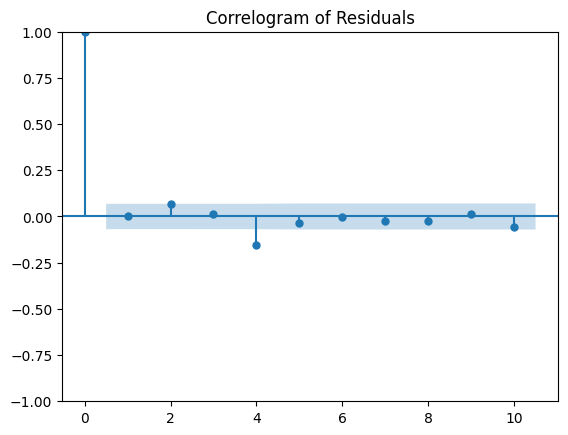

In [ ]:
check_assumptions(results, X)

We cannot use moving variance as a weight as it sees the future value.

In [ ]:
# with the crucial macro-economic factors
crucial_dates = ["2001-09-18", "2001-12-09", "2008-09-22", "2008-10-10", "2008-12-1", "2010-07-28",
                 "2011-08-12", "2013-05-29", "2016-06-30"]
crucial_dates = [pd.to_datetime(date) for date in crucial_dates]

In [ ]:
weights = get_weights(dates,crucial_dates)

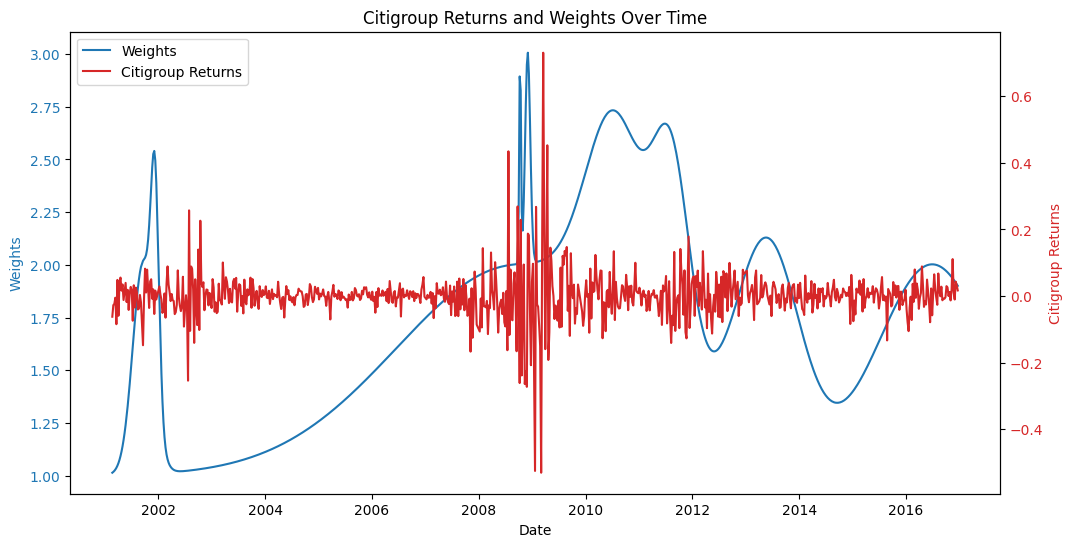

In [ ]:
dual_chart(dates, y, weights)

In [ ]:
results = sm.WLS(y, X, weights=weights).fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.225
Model:                            WLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     12.16
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           3.49e-33
Time:                        18:07:44   Log-Likelihood:                 1022.6
No. Observations:                 817   AIC:                            -2005.
Df Residuals:                     797   BIC:                            -1911.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

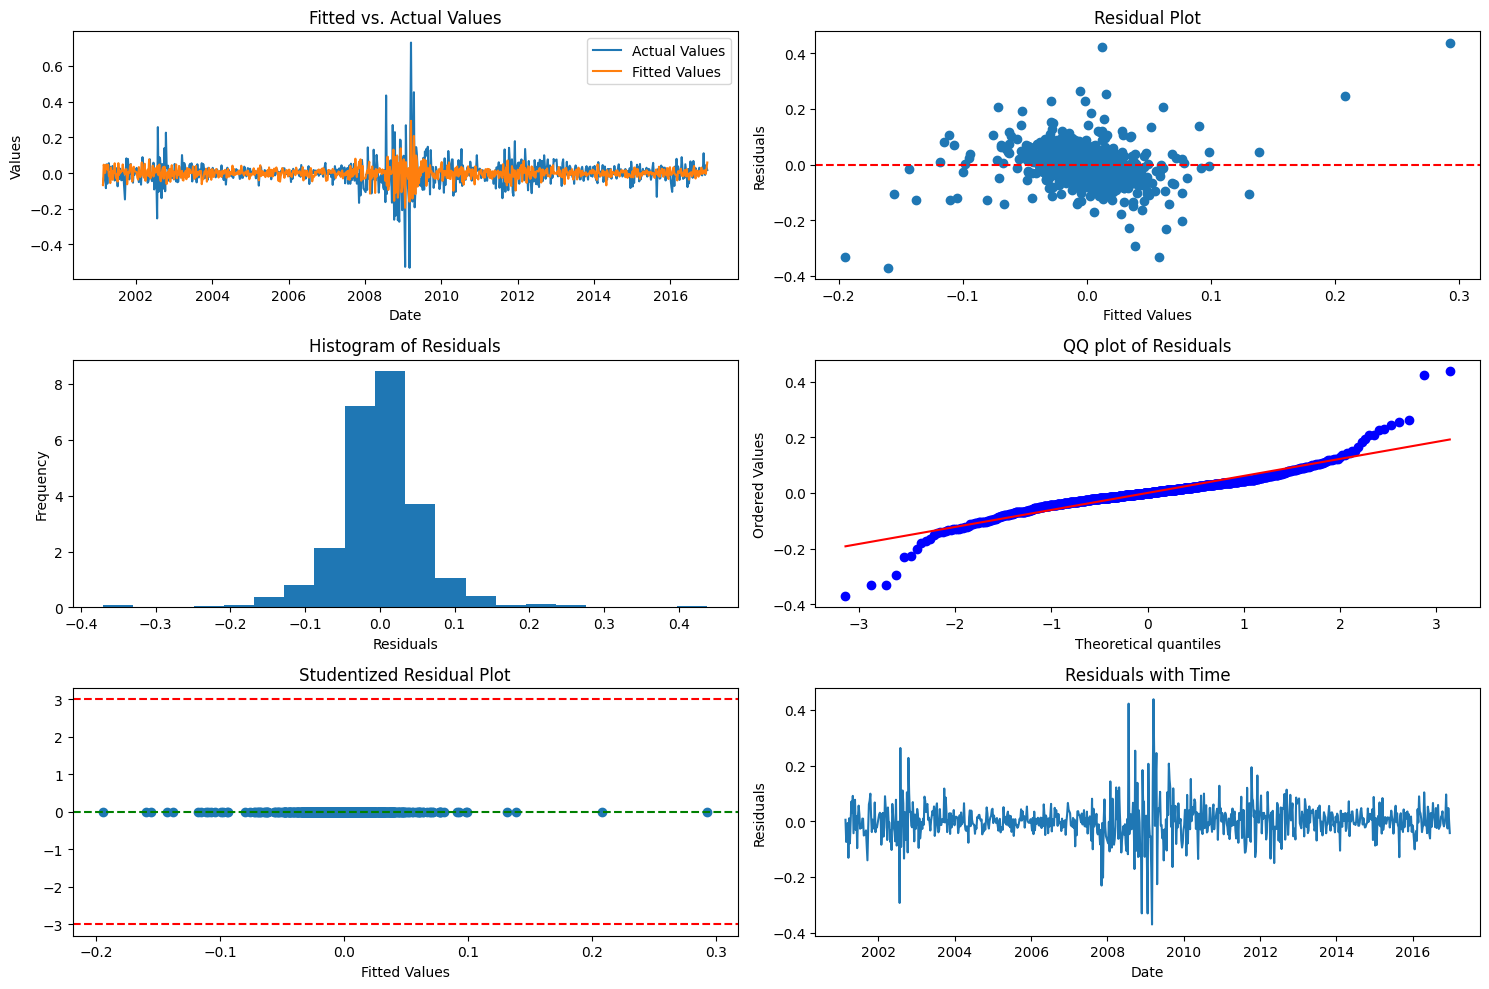

In [ ]:
diagnostic_plots(X, y, results, dates, robust=True)

Multicolinearity:
                         feature       VIF
0                          const  1.020644
1                 Citigroup_lag1  2.453622
2            JPMorgan Chase_lag1  2.972090
3             Goldman Sachs_lag1  3.886328
4            Morgan Stanley_lag1  4.231785
5                 Citigroup_lag2  3.714343
6           Bank of America_lag2  3.725852
7            JPMorgan Chase_lag2  2.988500
8            Morgan Stanley_lag2  2.498294
9            JPMorgan Chase_lag3  3.193149
10              Wells Fargo_lag3  2.492580
11           Morgan Stanley_lag3  2.412393
12              S&P500_diff_lag3  2.365196
13           Inflation_diff_lag3  1.056881
14                Citigroup_lag4  3.937670
15          Bank of America_lag4  4.429869
16           JPMorgan Chase_lag4  3.628623
17              Wells Fargo_lag4  3.427749
18           Morgan Stanley_lag4  2.549536
19  Federal Funds Rate_diff_lag4  1.056413
Normality:
Kolmogorov-Smirnov test p-value: 9.770024011332608e-138
Residuals ar

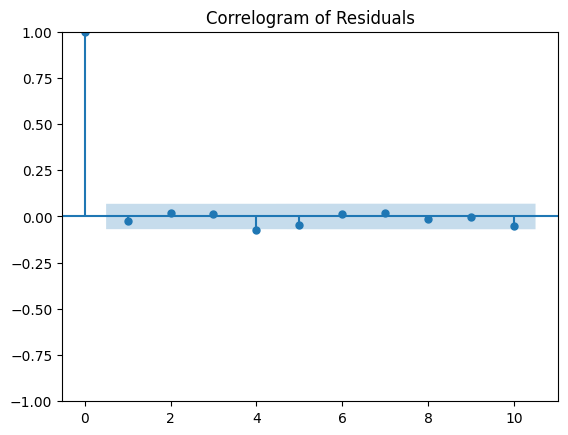

In [ ]:
check_assumptions(results, X)

In [ ]:
metrics = weighted_time_series_cross_validation(X,y,dates,cv=5)
metrics = pd.DataFrame(metrics)
metrics.apply(np.mean)

MAE         0.033307
RMSE        0.041876
AdjR2      -2.274333
AIC     -1119.106918
BIC     -1028.237451
dtype: float64

In [ ]:
weights = get_weights(dates,crucial_dates,y,variance=True)
weights = [weight * 10 for weight in weights]
if max(weights) == weights[0]:
  weights[0] = weights[1]

In [ ]:
weights = [weight + 0.1 for weight in weights]

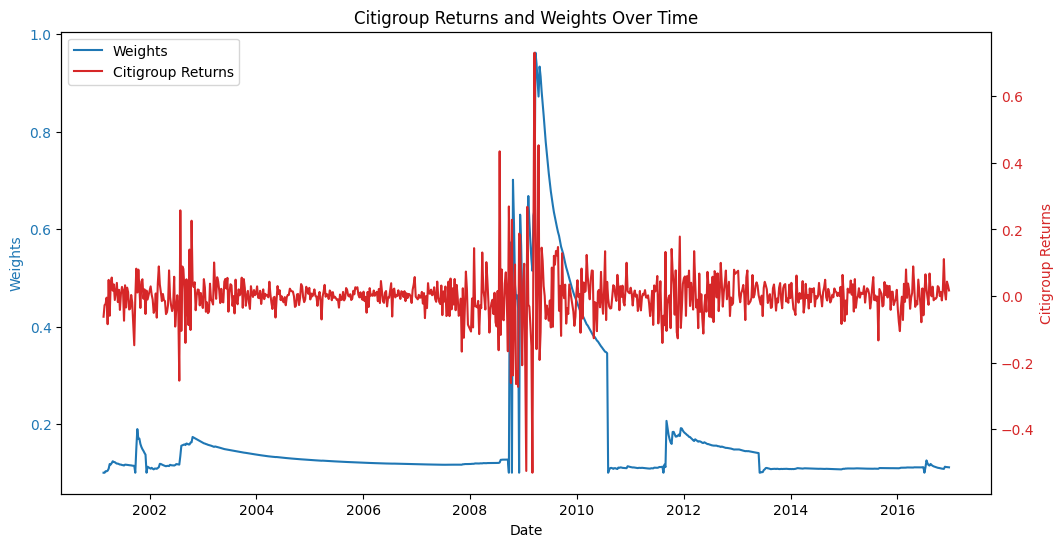

In [ ]:
dual_chart(dates, y, weights)

In [ ]:
results = sm.WLS(y, X, weights=weights).fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:              Citigroup   R-squared:                       0.415
Model:                            WLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     29.80
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           8.78e-80
Time:                        18:07:46   Log-Likelihood:                 815.36
No. Observations:                 817   AIC:                            -1591.
Df Residuals:                     797   BIC:                            -1497.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

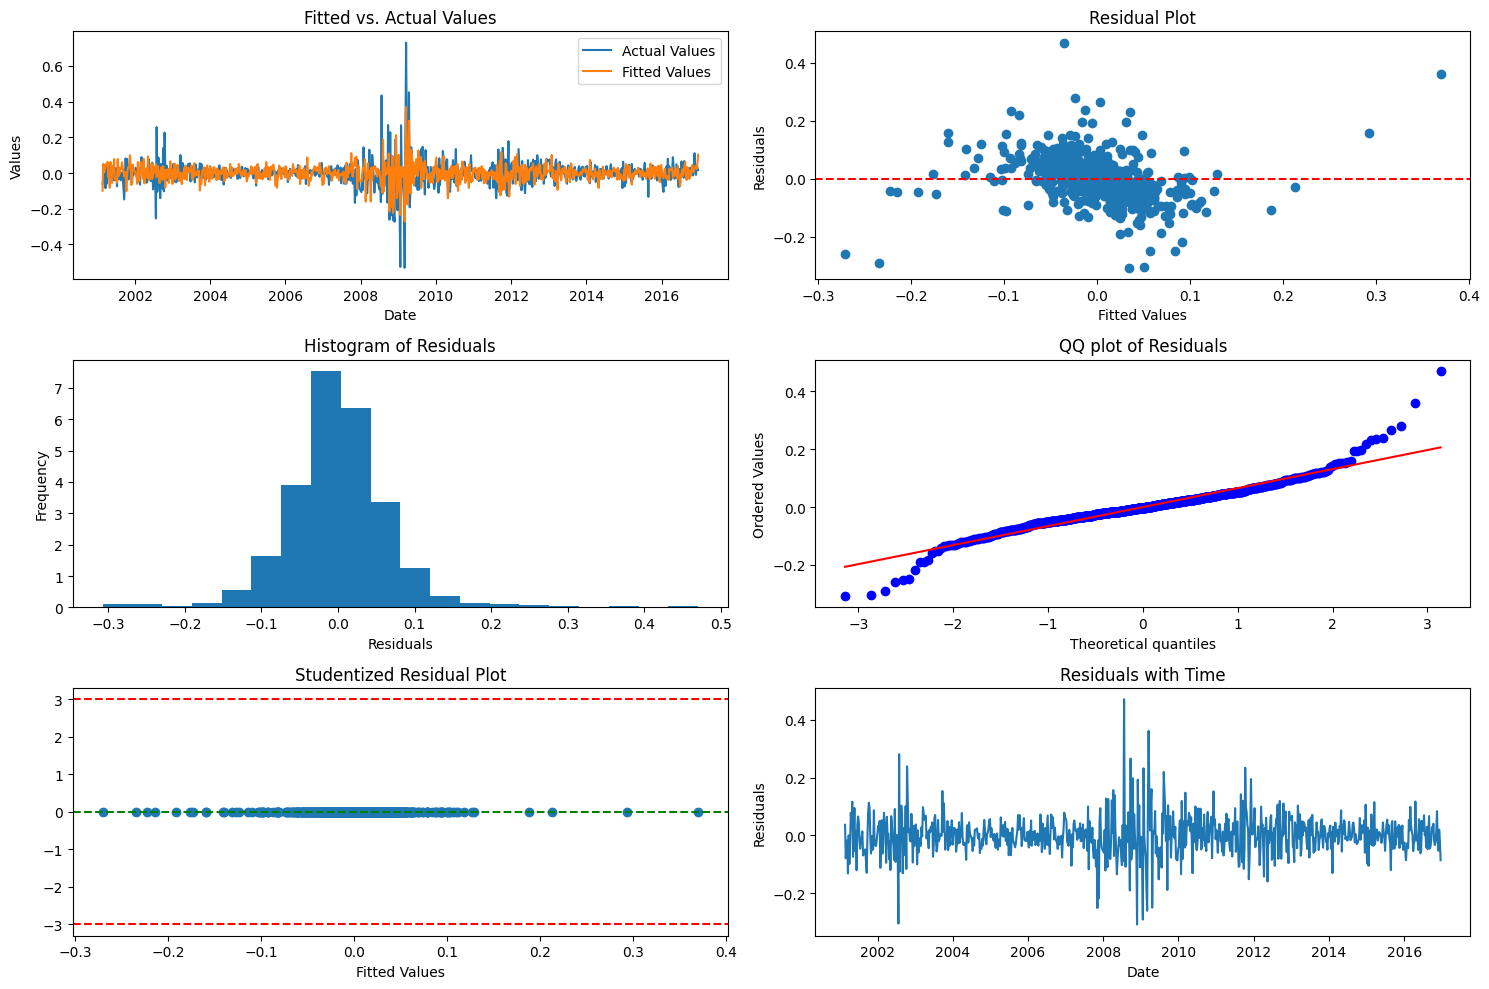

In [ ]:
diagnostic_plots(X, y, results, dates, robust=True)

Multicolinearity:
                         feature       VIF
0                          const  1.020644
1                 Citigroup_lag1  2.453622
2            JPMorgan Chase_lag1  2.972090
3             Goldman Sachs_lag1  3.886328
4            Morgan Stanley_lag1  4.231785
5                 Citigroup_lag2  3.714343
6           Bank of America_lag2  3.725852
7            JPMorgan Chase_lag2  2.988500
8            Morgan Stanley_lag2  2.498294
9            JPMorgan Chase_lag3  3.193149
10              Wells Fargo_lag3  2.492580
11           Morgan Stanley_lag3  2.412393
12              S&P500_diff_lag3  2.365196
13           Inflation_diff_lag3  1.056881
14                Citigroup_lag4  3.937670
15          Bank of America_lag4  4.429869
16           JPMorgan Chase_lag4  3.628623
17              Wells Fargo_lag4  3.427749
18           Morgan Stanley_lag4  2.549536
19  Federal Funds Rate_diff_lag4  1.056413
Normality:
Kolmogorov-Smirnov test p-value: 2.450670915457678e-137
Residuals ar

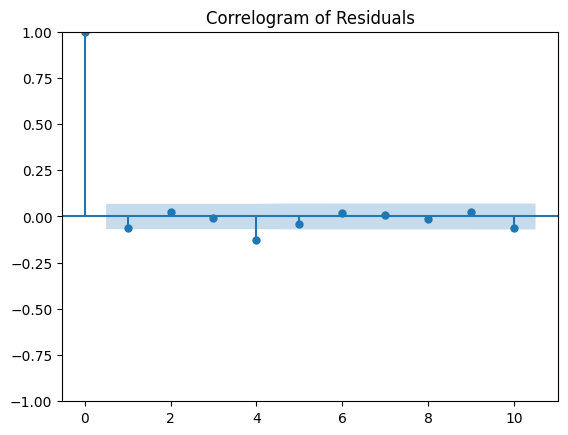

In [ ]:
check_assumptions(results, X)

## Quantile Regression

Becoz why not

In [ ]:
def quantile_regression_analysis(X, y, quantiles):
    """
    Performs quantile regression for various quantile values and evaluates model performance.

    Args:
        X (pd.DataFrame): Independent variables.
        y (pd.Series): Dependent variable.
        quantiles (list): List of quantile values to consider.

    Returns:
         pd.DataFrame: A DataFrame containing the metrics (AIC, BIC, R-squared) for each quantile.
    """
    results_dict = {}

    for q in quantiles:
        mod = QuantReg(y, X)
        res = mod.fit(q=q)
        results_dict[q] = {
            'Pseudo R2' : res.prsquared
        }
    return pd.DataFrame(results_dict).T, res

In [ ]:
quantiles_to_test = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_results, result = quantile_regression_analysis(X, y, quantiles_to_test)
quantile_results

Pseudo R2
0.10   0.098475
0.25   0.052559
0.50   0.038700
0.75   0.050680
0.90   0.104432

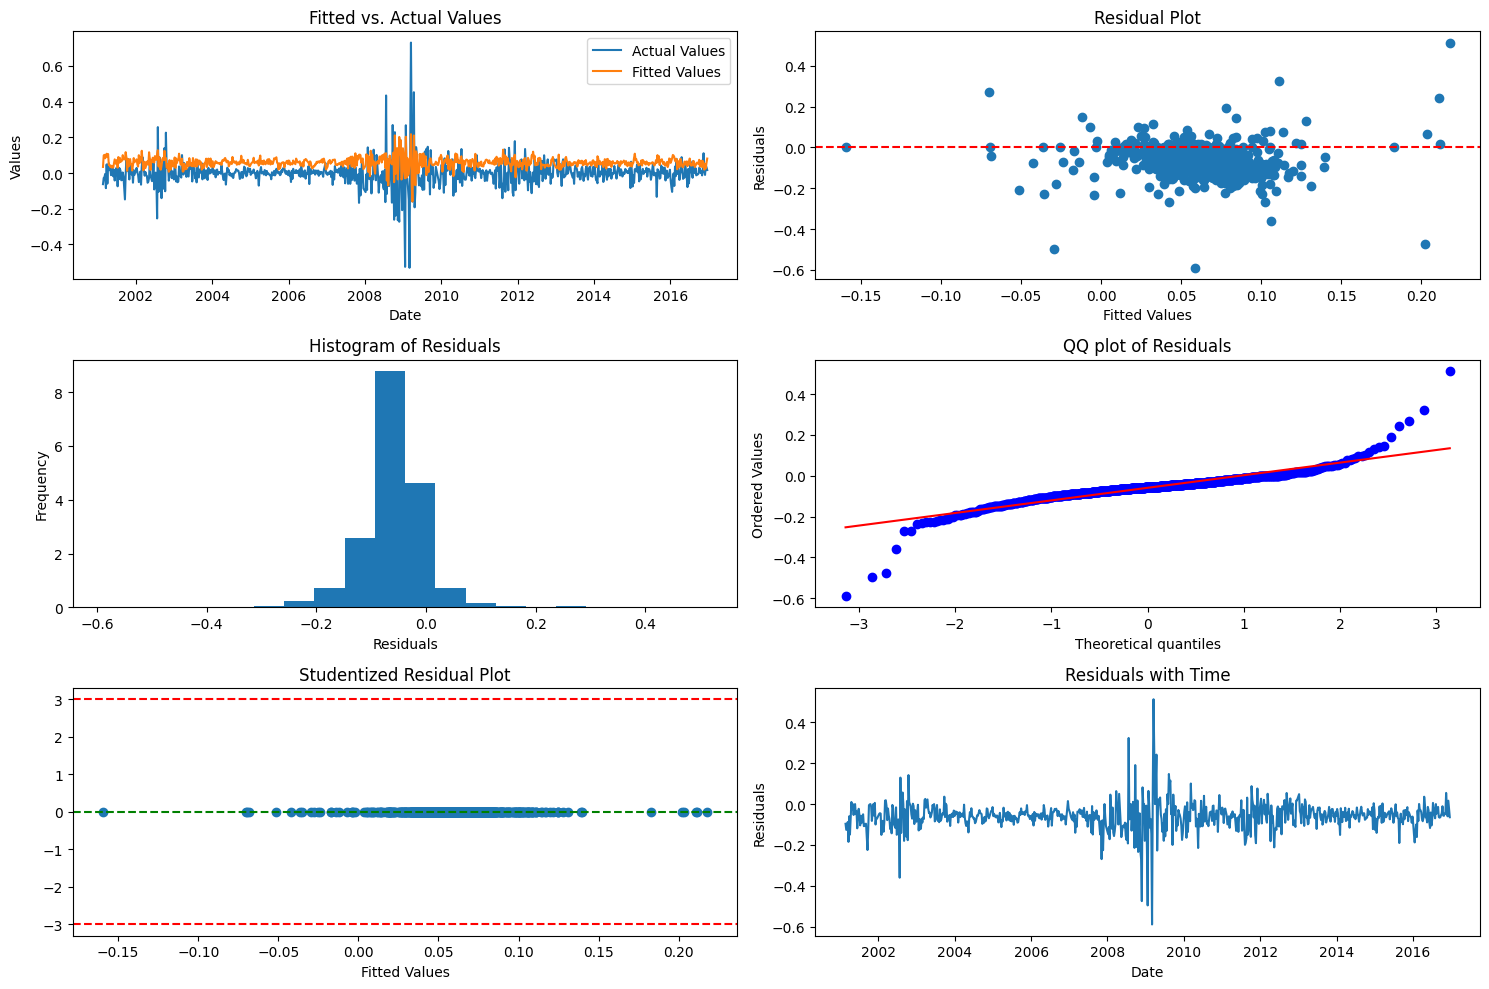

In [ ]:
diagnostic_plots(X, y, result,dates, robust=True)

Multicolinearity:
                         feature       VIF
0                          const  1.020644
1                 Citigroup_lag1  2.453622
2            JPMorgan Chase_lag1  2.972090
3             Goldman Sachs_lag1  3.886328
4            Morgan Stanley_lag1  4.231785
5                 Citigroup_lag2  3.714343
6           Bank of America_lag2  3.725852
7            JPMorgan Chase_lag2  2.988500
8            Morgan Stanley_lag2  2.498294
9            JPMorgan Chase_lag3  3.193149
10              Wells Fargo_lag3  2.492580
11           Morgan Stanley_lag3  2.412393
12              S&P500_diff_lag3  2.365196
13           Inflation_diff_lag3  1.056881
14                Citigroup_lag4  3.937670
15          Bank of America_lag4  4.429869
16           JPMorgan Chase_lag4  3.628623
17              Wells Fargo_lag4  3.427749
18           Morgan Stanley_lag4  2.549536
19  Federal Funds Rate_diff_lag4  1.056413
Normality:
Kolmogorov-Smirnov test p-value: 2.3081054658225705e-155
Residuals a

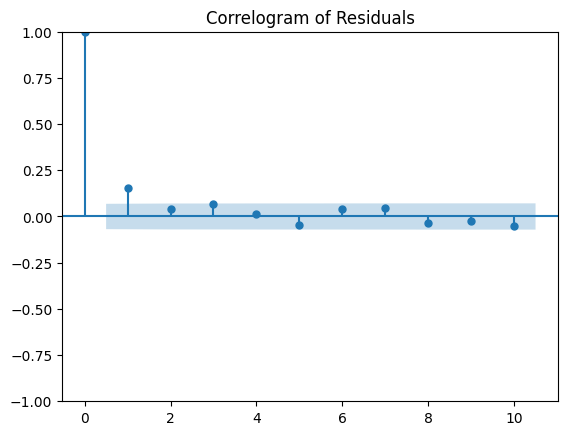

In [ ]:
check_assumptions(result, X)

### Stress Testing Citigroup Returns Under Adverse Scenarios

We assess the sensitivity of Citigroup's returns to adverse macroeconomic conditions and peer bank performance through scenario-based stress testing. This exercise leverages our post-2009 regression model, which includes lagged returns of peer banks and macroeconomic indicators.

#### 1. Methodology

Let $\hat{Y}_t $ be the predicted Citigroup return ratio from our regression model:

$$
\hat{Y}_t = \beta_0 + \sum_{i} \beta_i X_{it}
$$

We simulate shocks to key variables \( X_{it} \) such as:

- Peer bank return lags (e.g., JPMorgan_lag3, GoldmanSachs_lag4)
- Macroeconomic indicators (e.g., S&P500_diff, Inflation_diff)

#### 2. Scenarios

| Scenario | Description | Shock Magnitude |
|----------|-------------|-----------------|
| **Baseline** | Most recent observed values | No change |
| **Peer Bank Crisis** | Large negative returns in peer banks | -5% to -10% |
| **Macroeconomic Shock** | Drop in S&P 500, spike in inflation | -3% (S&P), +1% (Inflation) |
| **Combined Shock** | Both macro and peer bank stress | See above |

#### 3. Results

We recompute predicted Citigroup returns $ \hat{Y}_t^{stress} $ under each scenario and compare against baseline.

$
\Delta \hat{Y}_t = \hat{Y}_t^{stress} - \hat{Y}_t^{baseline}
$
A negative $ \Delta \hat{Y}_t $ indicates vulnerability to the stressor.

#### 4. Insights

The stress tests reveal which variables most influence Citigroup’s return behavior under crisis conditions, helping to identify risk channels.
